# –ì–µ–Ω–µ—Ä–∞—Ç–æ—Ä –æ—Ç–∑—ã–≤–æ–≤

## –ò–º–ø–æ—Ä—Ç –±–∏–±–ª–∏–æ—Ç–µ–∫

In [2]:
import wget

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import torch

import string
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
import os
import shutil
from datasets import Dataset, load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    GPT2LMHeadModel, 
    GPT2TokenizerFast, 
    Trainer, 
    TrainingArguments, 
    DataCollatorForLanguageModeling
)
from random import randint

%matplotlib inline

ModuleNotFoundError: No module named 'wget'

## EDA

### –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞—Ç–∞—Å–µ—Ç–∞

In [2]:
url = 'https://github.com/yandex/geo-reviews-dataset-2023/raw/refs/heads/master/geo-reviews-dataset-2023.tskv'
filename = wget.download(url)

### –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –≤ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º

In [3]:
# –°—á–∏—Ç–∞–µ–º –ø—Ä–∏ –ø–æ–º–æ—â–∏ pandas –∏—Å—Ö–æ–¥–Ω—ã–π —Ñ–∞–π–ª —Å —Ç–∞–±—É–ª—è—Ü–∏–µ–π –≤ –∫–∞—á–µ—Å—Ç–≤–µ —Ä–∞–∑–¥–µ–ª–∏—Ç–µ–ª—è, –∑–∞–¥–∞–≤ –Ω—É–∂–Ω—ã–µ –Ω–∞–º –∏–º–µ–Ω–∞ –∫–æ–ª–æ–Ω–æ–∫
df = pd.read_csv('geo-reviews-dataset-2023.tskv', sep='\t', header=None, names=['address', 'name_ru', 'rating', 'rubrics', 'text'])
columns = df.columns.to_list()
# –ü—Ä–æ–π–¥–µ–º –≤ —Ü–∏–∫–ª–µ –ø–æ –∫–æ–ª–æ–Ω–∫–∞–º –∏ —É–¥–∞–ª–∏–º –∏–∑ —è—á–µ–µ–∫ –∫–ª—é—á–∏
for column in columns:
    df[column] = df[column].replace(f'{column}=', '', regex=True)

In [4]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º –ø–µ—Ä–≤—ã–µ —Å—Ç—Ä–æ–∫–∏
df.head()

address             name_ru  \
0  –ï–∫–∞—Ç–µ—Ä–∏–Ω–±—É—Ä–≥, —É–ª. –ú–æ—Å–∫–æ–≤—Å–∫–∞—è / —É–ª. –í–æ–ª–≥–æ–≥—Ä–∞–¥—Å–∫...  –ú–æ—Å–∫–æ–≤—Å–∫–∏–π –∫–≤–∞—Ä—Ç–∞–ª   
1  –ú–æ—Å–∫–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å, –≠–ª–µ–∫—Ç—Ä–æ—Å—Ç–∞–ª—å, –ø—Ä–æ—Å–ø–µ–∫—Ç –õ–µ–Ω...   –ü—Ä–æ–¥—É–∫—Ç—ã –ï—Ä–º–æ–ª–∏–Ω–æ   
2  –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä, –ü—Ä–∏–∫—É–±–∞–Ω—Å–∫–∏–π –≤–Ω—É—Ç—Ä–∏–≥–æ—Ä–æ–¥—Å–∫–æ–π –æ–∫—Ä—É–≥,...             LimeFit   
3   –°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥, –ø—Ä–æ—Å–ø–µ–∫—Ç –≠–Ω–≥–µ–ª—å—Å–∞, 111, –∫–æ—Ä–ø. 1        Snow-Express   
4                  –¢–≤–µ—Ä—å, –í–æ–ª–æ–∫–æ–ª–∞–º—Å–∫–∏–π –ø—Ä–æ—Å–ø–µ–∫—Ç, 39  –°—Ç—É–¥–∏—è Beauty Brow   

  rating                                            rubrics  \
0     3.                                     –ñ–∏–ª–æ–π –∫–æ–º–ø–ª–µ–∫—Å   
1     5.  –ú–∞–≥–∞–∑–∏–Ω –ø—Ä–æ–¥—É–∫—Ç–æ–≤;–ü—Ä–æ–¥—É–∫—Ç—ã –≥–ª—É–±–æ–∫–æ–π –∑–∞–º–æ—Ä–æ–∑–∫–∏;...   
2     1.                                        –§–∏—Ç–Ω–µ—Å-–∫–ª—É–±   
3     4.        –ü—É–Ω–∫—Ç –ø—Ä–æ–∫–∞—Ç–∞;–ü—Ä–æ–∫–∞—Ç –≤–µ–ª–æ—Å–∏–ø–µ–¥–æ–≤;–°–∞–ø—Å—ë—Ä—Ñ–∏–Ω–≥   
4     5.  –°–∞–ª–æ–Ω –∫—Ä–∞—Å–æ—Ç—ã;–í–∏–∑–∞–∂–∏—Å—Ç—ã, —Å—Ç–∏–ª–∏—Å—Ç—ã;–°–∞–ª–æ–Ω –±—Ä–æ–≤–µ–π...   

                                                text  
0  –ú–æ—Å–∫–æ–≤—Å–∫–∏–π –∫–≤–∞—Ä—Ç–∞–ª 2.\n–®—É–º–Ω–æ : –ª–µ—Ç–æ–º –ø–æ –Ω–æ—á–∞–º ...  
1  –ó–∞–º–µ—á–∞—Ç–µ–ª—å–Ω–∞—è —Å–µ—Ç—å –º–∞–≥–∞–∑–∏–Ω–æ–≤ –≤ –æ–±—â–µ–º, —Ö–æ—Ä–æ—à–∏–π ...  
2  –ù–µ –∑–Ω–∞—é —Å–º—É—Ç—è—Ç –ª–∏ –∫–æ–≥–æ-—Ç–æ –¥–∞–Ω–Ω—ã–µ –ø—Ä–∞–≤–∏–ª–∞, –Ω–æ —è...  
3  –•–æ—Ä–æ—à–∏–µ —É—Å–ª–æ–≤–∏—è –∞—Ä–µ–Ω–¥—ã. \n–î—Ä—É–∂–µ–ª—é–±–Ω—ã–π –ø–µ—Ä—Å–æ–Ω–∞–ª...  
4  –¢–æ–ø –º–∞—Å—Ç–µ—Ä –ê–Ω–≥–µ–ª–∏–Ω–∞ —Ç–æ–ø –≤–æ –≤—Å–µ—Ö —Å–º—ã—Å–ª–∞—Ö ) –ù–µ–º–Ω...

### –ë–∞–∑–æ–≤—ã–π –∞–Ω–∞–ª–∏–∑ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞

–ü–æ—Å–º–æ—Ç—Ä–∏–º –æ—Å–Ω–æ–≤–Ω—É—é –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –ø–æ –Ω–∞—à–µ–º—É –¥–∞—Ç–∞—Ñ—Ä–µ–π–º—É

In [5]:
# –†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞
print(f'–†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞: {df.shape}')

–†–∞–∑–º–µ—Ä –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞: (500000, 5)


In [6]:
# –¢–∏–ø—ã –¥–∞–Ω–Ω—ã—Ö
print(df.dtypes)

address    object
name_ru    object
rating     object
rubrics    object
text       object
dtype: object


In [7]:
# –ö–æ–ª-–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π
df.nunique()

address    191925
name_ru    148461
rating        393
rubrics     32694
text       498918
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   address  500000 non-null  object
 1   name_ru  500000 non-null  object
 2   rating   500000 non-null  object
 3   rubrics  500000 non-null  object
 4   text     499030 non-null  object
dtypes: object(5)
memory usage: 19.1+ MB


–í–∏–¥–∏–º, —á—Ç–æ –≤ –∫–æ–ª–æ–Ω–∫–µ 'text' –µ—Å—Ç—å –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è. –ü–æ—Å–∫–æ–ª—å–∫—É –¥–∞–Ω–Ω—ã—Ö —É –Ω–∞—Å –æ—á–µ–Ω—å –º–Ω–æ–≥–æ, –∏ —Ü–µ–ª–∏–∫–æ–º –¥–∞—Ç–∞—Å–µ—Ç –º—ã –≤—Å–µ —Ä–∞–≤–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –Ω–µ –±—É–¥–µ–º (—Ç–∞–∫ –∫–∞–∫ –¥–æ–æ–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π —Ç–æ–≥–¥–∞ —Ä–∞—Å—Ç—è–Ω–µ—Ç—Å—è –Ω–∞ –Ω–µ—Å–∫–æ–ª—å–∫–æ –Ω–µ–¥–µ–ª—å), –ø—Ä–æ—Å—Ç–æ —É–¥–∞–ª–∏–º –≤—Å–µ —Å—Ç—Ä–æ–∫–∏, –≥–¥–µ –µ—Å—Ç—å –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è.

In [9]:
df = df.dropna(ignore_index=True)

In [10]:
# –ü—Ä–æ–≤–µ—Ä–∏–º –Ω–∞–ª–∏—á–∏–µ –¥—É–±–ª–∏–∫–∞—Ç–æ–≤
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
num_duplicates

np.int64(1)

In [11]:
df.loc[df.duplicated(keep=False), :]

address        name_ru rating  \
123882  –ö—Ä–∞—Å–Ω–æ—è—Ä—Å–∫, –Ø—Å—Ç—ã–Ω—Å–∫–∞—è —É–ª–∏—Ü–∞, 14  –°–ø–∞—Ä—Ç–∞ –ú–∞—Ä–∫–µ—Ç     5.   
123884  –ö—Ä–∞—Å–Ω–æ—è—Ä—Å–∫, –Ø—Å—Ç—ã–Ω—Å–∫–∞—è —É–ª–∏—Ü–∞, 14  –°–ø–∞—Ä—Ç–∞ –ú–∞—Ä–∫–µ—Ç     5.   

                                                  rubrics  \
123882  –ê–≤—Ç–æ–∞–∫—É—Å—Ç–∏–∫–∞;–¢–æ–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ –∞–≤—Ç–æ—Å—Ç—ë–∫–æ–ª;–ü–ª—ë–Ω–∫–∏ –∞—Ä—Ö...   
123884  –ê–≤—Ç–æ–∞–∫—É—Å—Ç–∏–∫–∞;–¢–æ–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ –∞–≤—Ç–æ—Å—Ç—ë–∫–æ–ª;–ü–ª—ë–Ω–∫–∏ –∞—Ä—Ö...   

                                                     text  
123882  –•–æ—Ä–æ—à–∏–µ –∫–æ–Ω—Å—É–ª—å—Ç–∞–Ω—Ç—ã, –≤–µ–∂–ª–∏–≤—ã–µ.\n–í—Å–µ –ø–æ–º–æ–≥–ª–∏ ,...  
123884  –•–æ—Ä–æ—à–∏–µ –∫–æ–Ω—Å—É–ª—å—Ç–∞–Ω—Ç—ã, –≤–µ–∂–ª–∏–≤—ã–µ.\n–í—Å–µ –ø–æ–º–æ–≥–ª–∏ ,...

–î–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ, —É –Ω–∞—Å –µ—Å—Ç—å –æ–¥–∏–Ω –¥—É–±–ª–∏–∫–∞—Ç

In [12]:
# –¢–µ–ø–µ—Ä—å –æ–±—Ä–µ–∂–µ–º —Ç–æ—á–∫—É –ø–æ—Å–ª–µ —Ü–∏—Ñ—Ä—ã –≤ –∫–æ–ª–æ–Ω–∫–µ 'rating' –∏ –ø—Ä–∏–≤–µ–¥–µ–º –∫–æ–ª–æ–Ω–∫—É –∫ —Ç–∏–ø—É int64
df['rating'] = df['rating'].replace('\.', '', regex=True)
df['rating'] = pd.to_numeric(df['rating'])

–ü–æ—Å–º–æ—Ç—Ä–∏–º, –∫–∞–∫ –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω—ã –æ—Ü–µ–Ω–∫–∏

<Axes: xlabel='rating', ylabel='Count'>

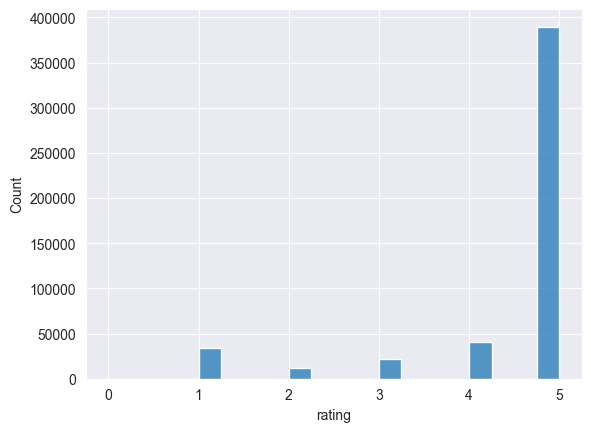

In [13]:
sns.histplot(df['rating'])

In [14]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º, —á—Ç–æ –∏–∑ —Å–µ–±—è –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è—é—Ç –æ—Ç–∑—ã–≤—ã –Ω–∞ 0 –±–∞–ª–ª–æ–≤
df.query('rating == 0').head()

address            name_ru  \
1906   –†–µ—Å–ø—É–±–ª–∏–∫–∞ –ö–∞—Ä–µ–ª–∏—è, –°—É–æ—è—Ä–≤–∏, —É–ª–∏—Ü–∞ –®–µ–ª—å—à–∞–∫–æ–≤–∞, 1  –ì–æ—Å—Ç–∏–Ω–∏—Ü–∞ –ö–∞—Ä–µ–ª–∏—è   
2164                   –ö–µ–º–µ—Ä–æ–≤–æ, —É–ª–∏—Ü–∞ –¢—É—Ö–∞—á–µ–≤—Å–∫–æ–≥–æ, 12           –°–≤–µ—Ç–æ—Ñ–æ—Ä   
3583       –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä—Å–∫–∏–π –∫—Ä–∞–π, –ê–Ω–∞–ø–∞, —É–ª–∏—Ü–∞ –ü—É—à–∫–∏–Ω–∞, 30             –ö—É–±–∞–Ω—å   
3614  –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä—Å–∫–∏–π –∫—Ä–∞–π, –¢—É–∞–ø—Å–∏–Ω—Å–∫–∏–π —Ä–∞–π–æ–Ω, –ù–æ–≤–æ–º–∏—Ö...   –°—á–∞—Å—Ç–ª–∏–≤—ã–π –•–æ—Ç–µ–π   
6384      –õ–µ–Ω–∏–Ω–≥—Ä–∞–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å, –í—ã–±–æ—Ä–≥, —É–ª–∏—Ü–∞ –ú–∏—Ä–∞, 8–ê             –ê—Ç—Ä–∏—É–º   

      rating                                            rubrics  \
1906       0                                          –ì–æ—Å—Ç–∏–Ω–∏—Ü–∞   
2164       0  –ú–∞–≥–∞–∑–∏–Ω –∞–≤—Ç–æ–∑–∞–ø—á–∞—Å—Ç–µ–π –∏ –∞–≤—Ç–æ—Ç–æ–≤–∞—Ä–æ–≤;–ê–≤—Ç–æ–∞–∫—Å–µ—Å—Å...   
3583       0                                          –°–∞–Ω–∞—Ç–æ—Ä–∏–π   
3614       0                                          –ì–æ—Å—Ç–∏–Ω–∏—Ü–∞   
6384       0                                     –¢–æ—Ä–≥–æ–≤—ã–π —Ü–µ–Ω—Ç—Ä   

                                                   text  
1906  –ì–æ—Å—Ç–∏–Ω–∏—Ü–∞ —Ä–∞—Å–ø–æ–ª–æ–∂–µ–Ω–Ω–∞ —É–¥–æ–±–Ω–æ, –µ—Å–ª–∏ –æ—Ç—Ä–µ–º–æ–Ω—Ç–∏—Ä...  
2164  –≠—Ç–æ –º–æ–π –ª—é–±–∏–º—ã–π –º–∞–≥–∞–∑–∏–Ω —Å –∑–∞–ø—á–∞—Å—Ç—è–º–∏. –ú–æ–∂–Ω–æ –≤—Å...  
3583  –ù–µ—Ç —Ä–∞—Å—Ç–∏—Ç–µ–ª—å–Ω–æ–≥–æ –º–∞—Å–ª–∞ –¥–ª—è —Å–∞–ª–∞—Ç–∞, –Ω–µ—Ç –∑—É–±–æ—á–∏...  
3614  –í—Å–µ –¥–æ–≤–æ–ª—å–Ω—ã, –∏ –≤–∑—Ä–æ—Å–ª—ã–µ –∏ –¥–µ—Ç–∏.\n–í–∫—É—Å–Ω–∞—è –µ–¥–∞....  
6384  –ë–æ–ª—å—à–æ–π –≤—ã–±–æ—Ä, –æ—á–µ–Ω—å –≥—Ä–∞–º–æ—Ç–Ω–æ –∏ —É–¥–æ–±–Ω–æ —Ä–∞–∑–ª–æ–∂–µ...

–ö–∞–∫ –º—ã –≤–∏–¥–∏–º, –æ—Ç–∑—ã–≤—ã –Ω–∞ 5 –∑–≤–µ–∑–¥ –ª—é–¥–∏ –æ—Å—Ç–∞–≤–ª—è—é—Ç –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ —á–∞—â–µ, —á–µ–º —Å –¥—Ä—É–≥–∏–º —Ä–µ–π—Ç–∏–Ω–≥–æ–º. –ù–∞–≤–µ—Ä–Ω–æ–µ, –≤ –¥–∞–ª—å–Ω–µ–π—à–µ–º –Ω–∞–º —Å—Ç–æ–∏—Ç —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞—Ç—å –∫–ª–∞—Å—Å—ã –¥–ª—è –æ–±—É—á–∞—é—â–µ–π –≤—ã–±–æ—Ä–∫–∏.
–¢–∞–∫ –∂–µ –µ—Å—Ç—å —à—É–º –≤ –≤–∏–¥–µ –æ—Ç–∑—ã–≤–æ–≤ –Ω–∞ 0 –±–∞–ª–ª–æ–≤ (—Ö–æ—Ç—è –µ—Å–ª–∏ –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å –Ω–∞ —Ç–µ–∫—Å—Ç —Ç–∞–∫–∏—Ö –æ—Ç–∑—ã–≤–æ–≤ - –æ–Ω –≤ –æ—Å–Ω–æ–≤–Ω–æ–º –ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã–π).

–î–æ–±–∞–≤–∏–º –≤ –Ω–∞—à –¥–∞—Ç–∞—Ñ—Ä–µ–π–º –∫–æ–ª–æ–Ω–∫—É, –≤ –∫–æ—Ç–æ—Ä–æ–π –±—É–¥–µ—Ç —É–∫–∞–∑–∞–Ω–∞ –¥–ª–∏–Ω–∞ –æ—Ç–∑—ã–≤–∞ –∏ –ø—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º –ø–æ–ª—É—á–µ–Ω–Ω—ã–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç.

In [15]:
df['review_length'] = df['text'].str.len()

In [16]:
df['review_length'].describe()

count    499030.000000
mean        303.232533
std         292.609661
min           2.000000
25%         145.000000
50%         215.000000
75%         365.000000
max       20162.000000
Name: review_length, dtype: float64

<Axes: xlabel='review_length', ylabel='Count'>

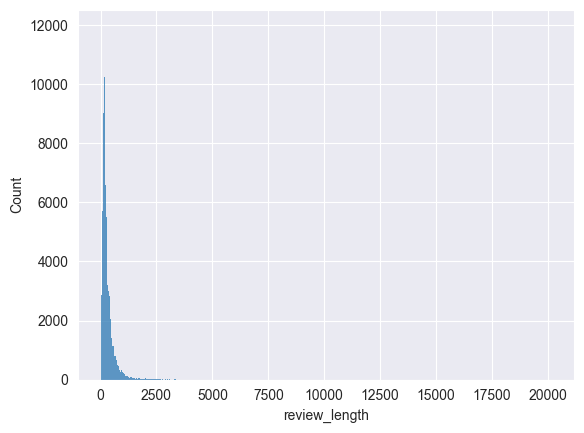

In [17]:
sns.histplot(df['review_length'])

<Axes: ylabel='review_length'>

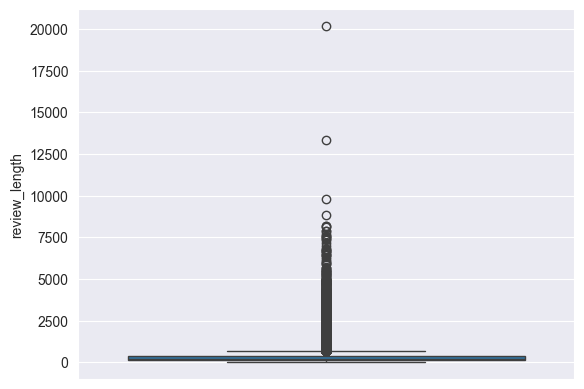

In [18]:
sns.boxplot(df['review_length'])

In [19]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º, –∫–∞–∫ –≤—ã–≥–ª—è–¥—è—Ç –æ—Ç–∑—ã–≤—ã –±–æ–ª–µ–µ 10000 —Å–∏–º–≤–æ–ª–æ–≤
df.query('review_length > 10000')['text'].values

array(['Que si, que no...\\n–ú–Ω–æ–≥–∞–∂–¥—ã –±—ã–≤–∞–ª –≤ —ç—Ç–æ–º –∑–∞–º–µ—á–∞—Ç–µ–ª—å–Ω–æ–º –æ—Ç–µ–ª–µ, –∏ —Å –∫–∞–∂–¥—ã–º —Ä–∞–∑–æ–º –≤—Å—ë –±–æ–ª—å—à–µ –∏ –±–æ–ª—å—à–µ —ç—Ç–∞ –ø–µ—Å–Ω—è –ø—Ä–æ —Ç—É–ø—è—â–µ–≥–æ –≤–ª—é–±–ª—ë–Ω–Ω–æ–≥–æ, —è–≤–ª—è—é—â–∞—è—Å—è –≥–∏–º–Ω–æ–º –æ—Ç–µ–ª—è, –≤—Å—ë —Ç–æ—á–Ω–µ–µ –∏ —Ç–æ—á–Ω–µ–µ –æ–ø–∏—Å—ã–≤–∞–µ—Ç –∫–∞—á–µ—Å—Ç–≤–æ –æ—Ç–¥—ã—Ö–∞. –í–æ–æ–±—â–µ, —ç—Ç–æ—Ç –≥–∏–º–Ω –ø—Ä–æ—Ç–∏–≤–æ—Ä–µ—á–∏—è–º –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ –æ—Ç—Ä–∞–∂–∞–µ—Ç –ø—Ä–æ–∏—Å—Ö–æ–¥—è—â–µ–µ —Å –í–∞–º–∏ –Ω–∞ –æ—Ç–¥—ã—Ö–µ –≤ –Ø–ª—Ç–∞ –ò–Ω—Ç—É—Ä–∏—Å—Ç.\\n–ù–∞—á–∏–Ω–∞–µ—Ç—Å—è –∑–Ω–∞–∫–æ–º—Å—Ç–≤–æ —Å –æ—Å–æ–±–µ–Ω–Ω–æ—Å—Ç—è–º–∏ —Å–µ—Ä–≤–∏—Å–∞ —Å–æ —Å–ª—É–∂–±—ã —Ä–∞–∑–º–µ—â–µ–Ω–∏—è (—ç—Ç–æ —Ç–µ, –∫–æ–≥–æ –Ω–∞–∑—ã–≤–∞—é—Ç —Ä–µ—Å–µ–ø—à–Ω). –ü—Ä–∏–≤–µ—Ç–ª–∏–≤–æ—Å—Ç—å —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤ –Ω–∞ —Å—Ç–æ–π–∫–µ —Ä–µ–≥–∏—Å—Ç—Ä–∞—Ü–∏–∏ –º–æ–∂–Ω–æ –≤—ã–¥–µ–ª–∏—Ç—å –æ—Ç–¥–µ–ª—å–Ω–æ, –í–∞—Å –≤—Å–µ–≥–¥–∞ –≤—Å—Ç—Ä–µ—Ç—è—Ç —Å —É–ª—ã–±–∫–æ–π, –≤—Å—ë —Ä–∞—Å—Å–∫–∞–∂—É—Ç –∏ –æ—Ç–≤–µ—Ç—è—Ç –Ω–∞ –í–∞—à–∏ –≤–æ–ø—Ä–

In [20]:
# –ò —Ç–∞–∫–∂–µ –∫–∞–∫ –≤—ã–≥–ª—è–¥—è—Ç –æ—Ç–∑—ã–≤—ã –º–µ–Ω–µ–µ 10 —Å–∏–º–≤–æ–ª–æ–≤
df.query('review_length < 10')['text'].values

array(['–ö—Ä—É—Ç–æ', '–ö—Ä—É—Ç–æ', '–∫–∞–π—Ñ\\n', '–í—Å–µ –∫—Ä—É—Ç–æ', '–û—Ç–ª–∏—á–Ω–æ ', '–û—Ç–ª–∏—á–Ω–æ!',
       '–ü—Ä–∏–ª–∏—á–Ω–æ ', '–õ—É—á—à–∏–µ!', '–ö–ª–∞—Å!', '–ö–ª–∞—Å—Å', '–•–æ—Ä–æ—à–æ ', '–£–¥–æ–±–Ω–æ',
       '–°—É–ø–µ—Ä', '–ù–µ –ø–ª–æ—Ö–æ ', '–ù–æ—Ä–º–∞–ª—å–Ω–æ', '–°–ø–∞—Å–∏–±–æ!', '–û—Ç–ª–∏—á–Ω–æ',
       '–°–ø–∞—Å–∏–±–æ', '–ù–æ—Ä–º', '–°—Ç–∞–Ω–¥–∞—Ä—Ç.', '–ß–∏—Å—Ç–æ!', '–í—Å–µ –æ—Ç–ª', '–£–¥–æ–±–Ω–æ',
       '–•–æ—Ä–æ—à–æ', '10 –∏–∑ 10', '–û–∫', '–í–∫—É—Å–Ω–æ', '–°—É–ø–µ—Ä', '–ù–æ—Ä–º', '–í–∫—É—Å–Ω–æ',
       '–ö—Ä–∞—Å–∞–≤—Ü—ã', '–ù–µ –≤–∫—É—Å–Ω–æ', '–í—Å–µ –Ω–æ—Ä–º.', '–ü—Ä–æ—Ñ–∏!', '–û—Ç–ª–∏—á–Ω–æ.',
       '–ö—Ä—É—Ç—å', '–ß–∏—Å—Ç–æ', '–û—Ç–ª–∏—á–Ω–æ.', '–•–æ—Ä–æ—à–æ ', '–ë–æ–º–±–∞', '–í—Å—ë —Å—É–ø–µ—Ä',
       '—Ç–æ–ø —Ç–æ–ø', '–ù–æ—Ä–º', '–í–ø–æ–ª–Ω–µ!', '–í—Å—ë —á√´—Ç–∫–æ', '–í–∫—É—Å–Ω–æ', '–ö–ª–∞—Å—Å! '],
      dtype=object)

–ö–∞–∫ –≤–∏–¥–∏–º, —É –Ω–∞—Å –ø—Ä–∏—Å—É—Ç—Å—Ç–≤—É—é—Ç –≤—ã–±—Ä–æ—Å—ã (–∫–∞–∫ —Å–ª–∏—à–∫–æ–º –º–∞–ª–µ–Ω—å–∫–∞—è –¥–ª–∏–Ω–∞ –æ—Ç–∑—ã–≤–∞, —Ç–∞–∫ –∏ —Å–ª–∏—à–∫–æ–º –±–æ–ª—å—à–∞—è).
–í –æ–±–æ–∏—Ö –≤–∞—Ä–∏–∞–Ω—Ç–∞—Ö –æ—Ç–∑—ã–≤—ã –ª–∏—à–µ–Ω—ã –∑–¥—Ä–∞–≤–æ–≥–æ —Å–º—ã—Å–ª–∞.
–í –¥–∞–ª—å–Ω–µ–π—à–µ–º –Ω—É–∂–Ω–æ –±—É–¥–µ—Ç —É–¥–∞–ª–∏—Ç—å —ç—Ç–∏ –≤—ã–±—Ä–æ—Å—ã –∏–∑ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞.

In [21]:
df_cor = df[['rating', 'review_length']]
df_cor

rating  review_length
0            3            537
1            5            158
2            1            485
3            4            142
4            5            373
...        ...            ...
499025       5             76
499026       4            295
499027       4            325
499028       5            502
499029       5            250

[499030 rows x 2 columns]

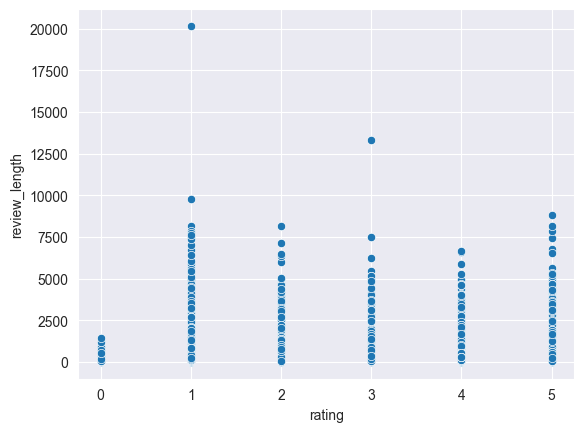

In [22]:
# –î–∏–∞–≥—Ä–∞–º–º–∞ —Ä–∞—Å—Å–µ—è–Ω–∏—è
sns.scatterplot(x='rating', y='review_length', data=df_cor)
plt.show()

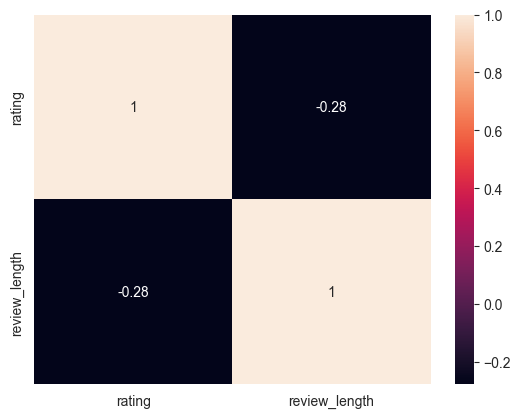

In [23]:
# –ö–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞
corr_matrix = df_cor.corr()

# –í–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–µ–º –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω—É—é –º–∞—Ç—Ä–∏—Ü—É
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [24]:
# –°–æ—Ö—Ä–∞–Ω–∏–º –Ω–∞—à –¥–∞—Ç–∞—Ñ—Ä–µ–π–º –≤ tsv —Ñ–∞–π–ª –¥–ª—è –¥–∞–ª—å–Ω–µ–π—à–µ–π —Ä–∞–±–æ—Ç—ã
df.to_csv('geo-reviews-dataset-2023.tsv', sep='\t', index=False)

### –†–∞—Å—á–µ—Ç —á–∞—Å—Ç–æ—Ç–Ω–æ—Å—Ç–∏ —Å–ª–æ–≤

–¢–µ–ø–µ—Ä—å –ø–æ—Å—á–∏—Ç–∞–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å–ª–æ–≤ –≤ –æ—Ç–∑—ã–≤–∞—Ö

In [25]:
# –°–æ–±–µ—Ä–µ–º –≤—Å–µ —Ç–µ–∫—Å—Ç—ã –æ—Ç–∑—ã–≤–æ–≤ –≤ –æ–¥–Ω—É —Å—Ç—Ä–æ–∫—É
words_list_list = df['text'].to_list()
words_str = ' '.join(str(string) for string in words_list_list)

In [26]:
# –£–¥–∞–ª–∏–º –∏–∑ —Å—Ç—Ä–æ–∫–∏ –≤—Å–µ —Å–ø–µ—Ü.—Å–∏–º–≤–æ–ª—ã
def remove_chars_from_text(text, chars):
    return "".join([char for char in text if char not in chars])

spec_chars = string.punctuation + '\n\xa0¬´¬ª\t‚Äî‚Ä¶n'

text = remove_chars_from_text(words_str, spec_chars)
text = remove_chars_from_text(text, string.digits)

# –ü—Ä–∏–≤–µ–¥–µ–º –≤—Å–µ —Å–ª–æ–≤–∞ –∫ –Ω–∏–∂–Ω–µ–º—É —Ä–µ–≥–∏—Å—Ç—Ä—É
text = text.lower()

In [27]:
# –¢–æ–∫–µ–Ω–∏–∑–∏—Ä—É–µ–º —Ç–µ–∫—Å—Ç
nltk.download('punkt_tab')
text_tokens = word_tokenize(text)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/johnneon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [28]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É –ø–æ –Ω–µ–æ—á–∏—â–µ–Ω–Ω—ã–º —Å–ª–æ–≤–∞–º


# –î–ª—è –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è –∏–Ω—Å—Ç—Ä—É–º–µ–Ω—Ç–æ–≤ —á–∞—Å—Ç–æ—Ç–Ω–æ–≥–æ –∞–Ω–∞–ª–∏–∑–∞ –±–∏–±–ª–∏–æ—Ç–µ–∫–∏ NLTK –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ —Å–ø–∏—Å–æ–∫ —Ç–æ–∫–µ–Ω–æ–≤ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞—Ç—å –∫ –∫–ª–∞—Å—Å—É Text
text = nltk.Text(text_tokens)
fdist = FreqDist(text)

print('–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ –Ω–µ–æ—á–∏—â–µ–Ω–Ω—ã–º —Å–ª–æ–≤–∞–º\n')
print(f'–í—Å–µ–≥–æ —Å–ª–æ–≤: {fdist.N()}\n')
print(f'–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å–ª–æ–≤: {fdist.B()}\n')
print('–¢–æ–ø-10 —Å–ª–æ–≤ –ø–æ —á–∞—Å—Ç–æ—Ç–µ: ')
most_common_words = fdist.most_common(10)
for word in most_common_words:
    print(f'{word[0]}:  {word[1]}')

–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ –Ω–µ–æ—á–∏—â–µ–Ω–Ω—ã–º —Å–ª–æ–≤–∞–º

–í—Å–µ–≥–æ —Å–ª–æ–≤: 21306636

–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å–ª–æ–≤: 742932

–¢–æ–ø-10 —Å–ª–æ–≤ –ø–æ —á–∞—Å—Ç–æ—Ç–µ: 
–∏:  874480
–≤:  604858
–Ω–µ:  400240
–Ω–∞:  389339
–æ—á–µ–Ω—å:  298972
—Å:  289708
—á—Ç–æ:  205890
–≤—Å–µ:  170685
–Ω–æ:  141965
–ø–æ:  137147


In [29]:
# –¢–µ–ø–µ—Ä—å –æ—á–∏—Å—Ç–∏–º —Å–ª–æ–≤–∞ –æ—Ç —Å–ª—É–∂–µ–±–Ω—ã—Ö —á–∞—Å—Ç–µ–π —Ä–µ—á–∏
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")
custom_stopwords = ['–æ—á–µ–Ω—å', '—ç—Ç–æ', '–≤—Å—ë', '–≤—Å–µ–º', '–µ—â–µ', '–µ—â—ë']
stopwords_united = russian_stopwords + custom_stopwords
text_with_no_stopwords = [word for word in text if word not in stopwords_united]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnneon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# –ò –ø–æ—Å–º–æ—Ç—Ä–∏–º —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É –ø–æ –æ—á–∏—â–µ–Ω–Ω—ã–º —Å–ª–æ–≤–∞–º

fdist = FreqDist(text_with_no_stopwords)

print('–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ –æ—á–∏—â–µ–Ω–Ω—ã–º —Å–ª–æ–≤–∞–º\n')
print(f'–í—Å–µ–≥–æ —Å–ª–æ–≤: {fdist.N()}\n')
print(f'–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å–ª–æ–≤: {fdist.B()}\n')
print('–¢–æ–ø-10 —Å–ª–æ–≤ –ø–æ —á–∞—Å—Ç–æ—Ç–µ: ')
most_common_words = fdist.most_common(10)
for word in most_common_words:
    print(f'{word[0]}:  {word[1]}')

–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ –æ—á–∏—â–µ–Ω–Ω—ã–º —Å–ª–æ–≤–∞–º

–í—Å–µ–≥–æ —Å–ª–æ–≤: 14173971

–£–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å–ª–æ–≤: 742776

–¢–æ–ø-10 —Å–ª–æ–≤ –ø–æ —á–∞—Å—Ç–æ—Ç–µ: 
–ø–µ—Ä—Å–æ–Ω–∞–ª:  82456
–º–µ—Å—Ç–æ:  74975
—Å–ø–∞—Å–∏–±–æ:  73776
—Ä–µ–∫–æ–º–µ–Ω–¥—É—é:  60037
–ø—Ä–æ—Å—Ç–æ:  49583
–º–∞–≥–∞–∑–∏–Ω:  46361
—Ö–æ—Ä–æ—à–∏–π:  43166
—Ü–µ–Ω—ã:  42268
–≤–∫—É—Å–Ω–æ:  40279
–±—ã—Å—Ç—Ä–æ:  40030


<Axes: xlabel='Samples', ylabel='Counts'>

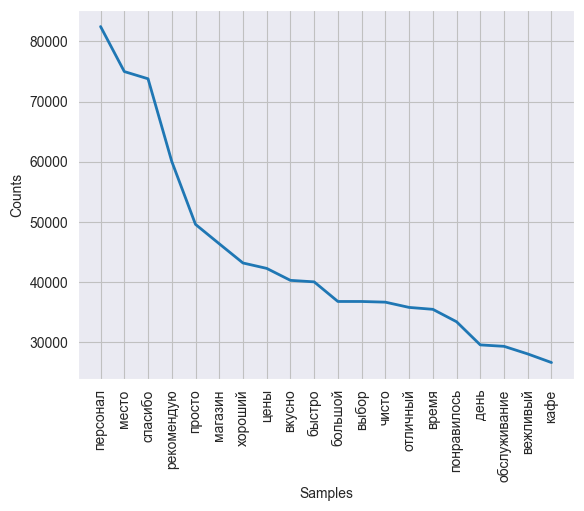

In [31]:
# –ß—Ç–æ–±—ã –¥–æ–±–∞–≤–∏—Ç—å —Å—é–¥–∞ —á—Ç–æ-–Ω–∏–±—É–¥—å –∫—Ä–∞—Å–∏–≤–æ–µ - –Ω–∞—Ä–∏—Å—É–µ–º –≥—Ä–∞—Ñ–∏–∫ —á–∞—Å—Ç–æ—Ç—ã —Ç–æ–ø-20 –æ—á–∏—â–µ–Ω–Ω—ã—Ö —Å–ª–æ–≤

fdist.plot(20,cumulative=False)

### –û–±–ª–∞–∫–æ —Å–ª–æ–≤

–°–æ—Å—Ç–∞–≤–∏–º –æ–±–ª–∞–∫–æ –æ—á–∏—â–µ–Ω–Ω—ã—Ö —Å–ª–æ–≤ –ø–æ —á–∞—Å—Ç–æ—Ç–µ —É–ø–æ—Ç—Ä–µ–±–ª–µ–Ω–∏—è

In [32]:
wordcloud = WordCloud(width=1200, height=600).generate_from_frequencies(fdist)

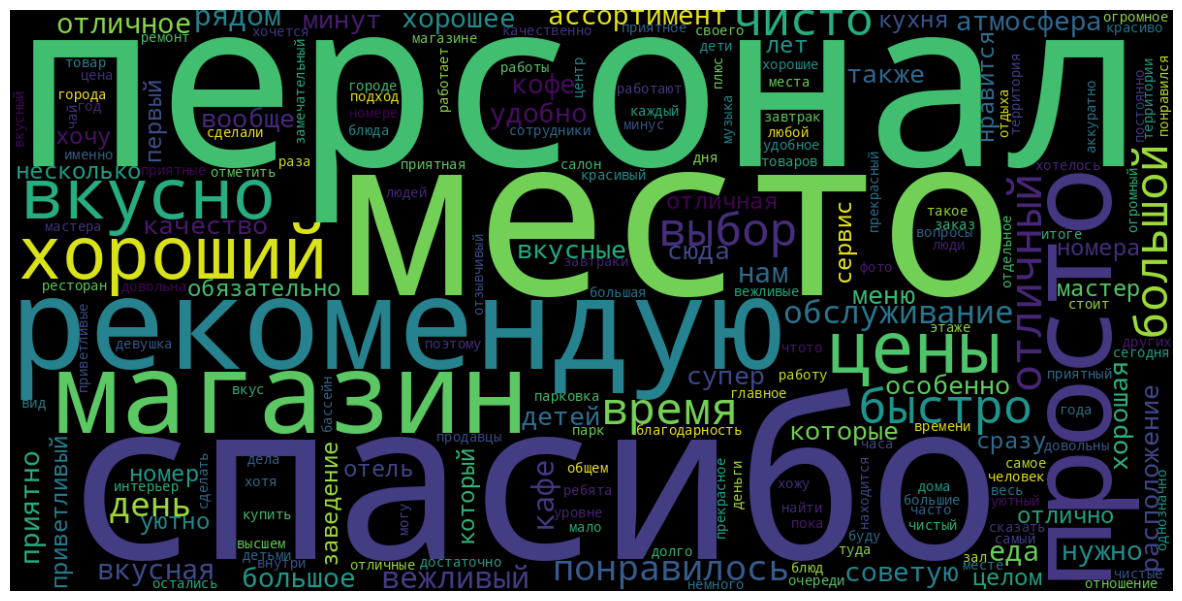

In [33]:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


–í—ã–≤–æ–¥—ã –ø–æ —ç—Ç–∞–ø—É EDA:
1. –ù—É–∂–Ω–æ —É–¥–∞–ª–∏—Ç—å —Å—Ç—Ä–æ–∫–∏ —Å –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏
2. –ù—É–∂–Ω–æ —É–¥–∞–ª–∏—Ç—å –¥—É–±–ª–∏–∫–∞—Ç—ã
3. –ù—É–∂–Ω–æ —É–¥–∞–ª–∏—Ç—å —Å—Ç—Ä–æ–∫–∏ —Å –æ—Ç–∑—ã–≤–∞–º–∏ –Ω–∞ 0 –±–∞–ª–ª–æ–≤
4. –ù—É–∂–Ω–æ —É–¥–∞–ª–∏—Ç—å —Å—Ç—Ä–æ–∫–∏ —Å–æ —Å–ª–∏—à–∫–æ–º –±–æ–ª—å—à–æ–π –∏ —Å–ª–∏—à–∫–æ–º –º–∞–ª–µ–Ω—å–∫–æ–π –¥–ª–∏–Ω–æ–π —Ç–µ–∫—Å—Ç–∞ –æ—Ç–∑—ã–≤–∞
5. –í–æ–∑–º–æ–∂–Ω–æ, –¥–ª—è –¥–∞–ª—å–Ω–µ–π—à–µ–≥–æ –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–µ–π —Å—Ç–æ–∏—Ç —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞—Ç—å –∫–ª–∞—Å—Å—ã –æ—Ç–∑—ã–≤–æ–≤ –ø–æ –∑–Ω–∞—á–µ–Ω–∏—è–º —Ä–µ–π—Ç–∏–≥–∞ 

## –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞

In [34]:
# –ò—Å—Ö–æ–¥–Ω—ã–π –¥–∞—Ç–∞—Ñ—Ä–µ–π–º
df = pd.read_csv('geo-reviews-dataset-2023.tsv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499030 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        499030 non-null  object
 1   name_ru        499030 non-null  object
 2   rating         499030 non-null  int64 
 3   rubrics        499030 non-null  object
 4   text           499030 non-null  object
 5   review_length  499030 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 22.8+ MB


–°—Ç—Ä–æ–∫–∏ —Å –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏ –∏ –¥—É–±–ª–∏–∫–∞—Ç—ã –±—ã–ª–∏ —É–¥–∞–ª–µ–Ω—ã –Ω–∞ –ø—Ä–æ—à–ª—ã—Ö —ç—Ç–∞–ø–∞—Ö

–ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è —Ç–µ–∫—Å—Ç–æ–≤ (—É–¥–∞–ª–µ–Ω–∏–µ —Å–ø–µ—Ü—Å–∏–º–≤–æ–ª–æ–≤, –ø—Ä–∏–≤–µ–¥–µ–Ω–∏–µ –∫ –Ω–∏–∂–Ω–µ–º—É —Ä–µ–≥–∏—Å—Ç—Ä—É):

In [35]:
def normalize_text(text):
    # –ü—Ä–∏–≤–µ–¥–µ–Ω–∏–µ –∫ –Ω–∏–∂–Ω–µ–º—É —Ä–µ–≥–∏—Å—Ç—Ä—É
    text = text.lower()
    
    # –£–¥–∞–ª–µ–Ω–∏–µ —Å–ø–µ—Ü–∏–∞–ª—å–Ω—ã—Ö —Å–∏–º–≤–æ–ª–æ–≤
    text = re.sub(r'[^a-zA-Z–∞-—è–ê-–Ø0-9\s]', '', text)
    
    return text

# –ü—Ä–∏–º–µ–Ω—è–µ–º —Ñ—É–Ω–∫—Ü–∏—é –∫–æ –≤—Å–µ–º –æ—Ç–∑—ã–≤–∞–º
df['text'] = df['text'].apply(normalize_text)


–û–±—Ä–∞–±–æ—Ç–∫–∞ –∫–∞—Ç–µ–≥–æ—Ä–∏–π

In [36]:
# –ü–æ—Å–º–æ—Ç—Ä–∏–º —Å–∫–æ–ª—å–∫–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –ø–æ —Å—Ç–æ–ª–±—Ü–∞–º
df.nunique()

address          191639
name_ru          148456
rating                6
rubrics           31724
text             498805
review_length      3004
dtype: int64

–ë–æ–ª—å—à–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–º –ø—Ä–∏–∑–Ω–∞–∫–∞–º, —Å—á–∏—Ç–∞—é –ø—Ä–∏–º–µ–Ω–µ–Ω–∏–µ onehot –∫–æ–¥–∏—Ä–æ–≤–∞–Ω–∏—è –Ω–µ—Ä–µ–Ω—Ç–∞–±–µ–ª—å–Ω—ã–º

–ì—Ä—É–ø–ø–∏—Ä–æ–≤–∫–∞ –∫–∞—Ç–µ–≥–æ—Ä–∏–π —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –∫–æ—Ç–æ—Ä—ã—Ö –≤—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è —Ä–µ–∂–µ –≤—Å–µ–≥–æ

In [37]:
# C–≥—Ä—É–ø–ø–∏—Ä–æ–≤–∞—Ç—å –≤—Å–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏, –∫–æ—Ç–æ—Ä—ã–µ –≤—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è –º–µ–Ω–µ–µ —á–µ–º –≤ 0.00021% —Å–ª—É—á–∞–µ–≤
category_counts = df['rubrics'].value_counts(normalize=True)
rare_categories = category_counts[category_counts < 0.0000021].index

rare_categories

Index(['–û—Ñ–∏—Å –∏–Ω—Ç–µ—Ä–Ω–µ—Ç-–º–∞–≥–∞–∑–∏–Ω–∞;–ó–æ–æ–º–∞–≥–∞–∑–∏–Ω;–î–æ—Å—Ç–∞–≤–∫–∞ –ø—Ä–æ–¥—É–∫—Ç–æ–≤',
       '–°–ø–æ—Ä—Ç–∏–≤–Ω—ã–π, —Ç—Ä–µ–Ω–∞–∂—ë—Ä–Ω—ã–π –∑–∞–ª;–°–ø–æ—Ä—Ç–∏–≤–Ω–∞—è –±–∞–∑–∞;–ê—Ä–µ–Ω–¥–∞ –ø–ª–æ—â–∞–¥–æ–∫ –¥–ª—è –∫—É–ª—å—Ç—É—Ä–Ω–æ-–º–∞—Å—Å–æ–≤—ã—Ö –º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏–π',
       '–ú–∞–≥–∞–∑–∏–Ω –º—è—Å–∞, –∫–æ–ª–±–∞—Å;–ü—Ä–æ–¥—É–∫—Ç—ã –≥–ª—É–±–æ–∫–æ–π –∑–∞–º–æ—Ä–æ–∑–∫–∏;–ú–æ–ª–æ—á–Ω—ã–π –º–∞–≥–∞–∑–∏–Ω;–ú–∞–≥–∞–∑–∏–Ω –∫—É–ª–∏–Ω–∞—Ä–∏–∏;–ú–∞–≥–∞–∑–∏–Ω —Å—ã—Ä–æ–≤',
       '–°–∏—Å—Ç–µ–º—ã –≤–æ–¥–æ—Å–Ω–∞–±–∂–µ–Ω–∏—è –∏ –∫–∞–Ω–∞–ª–∏–∑–∞—Ü–∏–∏;–û—Ç–æ–ø–∏—Ç–µ–ª—å–Ω–æ–µ –æ–±–æ—Ä—É–¥–æ–≤–∞–Ω–∏–µ –∏ —Å–∏—Å—Ç–µ–º—ã;–ú–æ–Ω—Ç–∞–∂ –∏ –æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ —Å–∏—Å—Ç–µ–º –≤–æ–¥–æ—Å–Ω–∞–±–∂–µ–Ω–∏—è –∏ –∫–∞–Ω–∞–ª–∏–∑–∞—Ü–∏–∏',
       '–ö–æ–ø–∏—Ä–æ–≤–∞–ª—å–Ω—ã–π —Ü–µ–Ω—Ç—Ä;–ü–µ—á–∞—Ç–∏ –∏ —à—Ç–∞–º–ø—ã;–ú–∞–≥–∞–∑–∏–Ω –∫–∞–Ω—Ü—Ç–æ–≤–∞—Ä–æ–≤;–¢–∏–ø–æ–≥—Ä–∞—Ñ–∏—è',
       '–î–∏–∞–≥–Ω–æ—Å—Ç–∏—á–µ—Å–∫–∏–π —Ü–µ–Ω—Ç—Ä;–ü–æ–ª–∏–∫–ª–∏–Ω–∏–∫–∞ –¥–ª—è –≤–∑—Ä–æ—Å–ª—ã—Ö;–ú–µ–¥—Å–∞–Ω—á–∞—Å—Ç—å'

–ï—Å—Ç—å –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ –∫–æ—Ç–æ—Ä—ã–µ –≤—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è —Ä–µ–¥–∫–æ –≤ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–µ, –Ω–æ –ø–æ —Å–º—ã—Å–ª—É —Ä–∞–∑–Ω—ã–µ –∏ –º–æ–≥—É—Ç –ø—Ä–∏–≥–æ–¥–∏—Ç—å—Å—è –¥–ª—è –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ –æ—Ç–∑—ã–≤–æ–≤. –°—á–∏—Ç–∞—é, —á—Ç–æ –Ω–µ –Ω—É–∂–Ω–æ –≥—Ä—É–ø–ø–∏—Ä–æ–≤–∞—Ç—å –∏—Ö –≤ –æ–¥–Ω—É –∫–∞—Ç–µ–≥–æ—Ä–∏—é.

–£–¥–∞–ª—è–µ–º —Å—Ç—Ä–æ–∫–∏ —Å —Ä–µ–π—Ç–∏–Ω–≥–æ–º 0

In [38]:
# –£–±–∏—Ä–∞–µ–º —Å—Ç—Ä–æ–∫–∏ —Å —Ä–µ–π—Ç–∏–Ω–≥–æ–º 0
df = df.query("rating > 0")

# –í—ã–≤–æ–¥–∏–º –∫–æ–ª-–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π –ø–æ –∫–æ–ª–æ–Ω–∫–∞–º –¥–ª—è –ø—Ä–æ–≤–µ—Ä–∫–∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞
df.nunique()

address          191595
name_ru          148421
rating                5
rubrics           31715
text             498606
review_length      3004
dtype: int64

<Axes: xlabel='rating', ylabel='Count'>

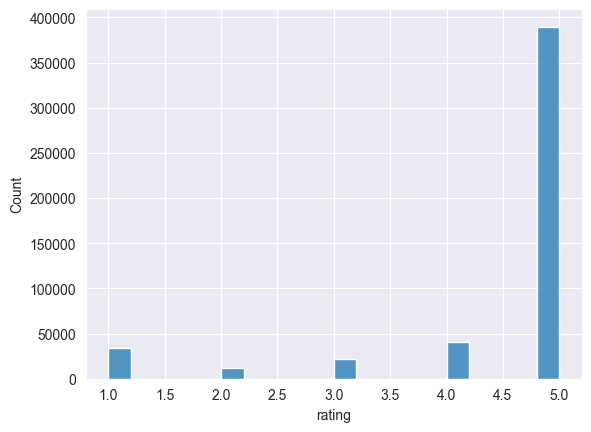

In [39]:
# –í—ã–≤–µ–¥–µ–º –≥—Ä–∞—Ñ–∏–∫ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
sns.histplot(df['rating'])

In [40]:
# –ü—Ä–æ–≤–µ—Ä–∏–º —Å–∫–æ–ª—å–∫–æ —Å—Ç—Ä–æ–∫ —É–¥–∞–ª–∏–ª–æ—Å—å –ø–æ—Å–ª–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–π
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498830 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498830 non-null  object
 1   name_ru        498830 non-null  object
 2   rating         498830 non-null  int64 
 3   rubrics        498830 non-null  object
 4   text           498830 non-null  object
 5   review_length  498830 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.6+ MB


–£–¥–∞–ª–∏–ª–æ—Å—å 200 —Å—Ç—Ä–æ–∫

–£–¥–∞–ª—è–µ–º —Å—Ç—Ä–æ–∫–∏ —Å–æ —Å–ª–∏—à–∫–æ–º –±–æ–ª—å—à–æ–π –∏ —Å–ª–∏—à–∫–æ–º –º–∞–ª–µ–Ω—å–∫–æ–π –¥–ª–∏–Ω–æ–π —Ç–µ–∫—Å—Ç–∞ –æ—Ç–∑—ã–≤–∞

In [41]:
# –£–¥–∞–ª–µ–Ω–∏–µ –æ—Ç–∑—ã–≤–æ–≤ —Å –¥–ª–∏–Ω–æ–π –±–æ–ª–µ–µ 4000 —Å–ª–æ–≤
df = df.query('review_length < 4000')

# –£–¥–∞–ª–µ–Ω–∏–µ –æ—Ç–∑—ã–≤–æ–≤ —Å –¥–ª–∏–Ω–æ–π –º–µ–Ω–µ–µ 10 —Å–ª–æ–≤
df = df.query('review_length > 10')

In [42]:
# –ü—Ä–æ–≤–µ—Ä—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498639 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498639 non-null  object
 1   name_ru        498639 non-null  object
 2   rating         498639 non-null  int64 
 3   rubrics        498639 non-null  object
 4   text           498639 non-null  object
 5   review_length  498639 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.6+ MB


–£–¥–∞–ª–∏–ª–æ—Å—å –µ—â–µ 191 —Å—Ç—Ä–æ–∫–∞

<Axes: xlabel='review_length', ylabel='Count'>

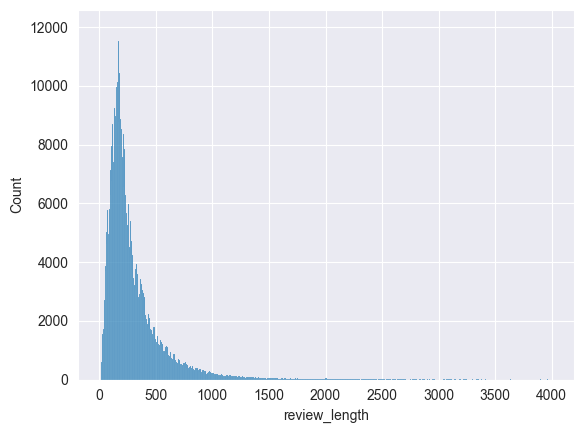

In [43]:
# –í—ã–≤–µ–¥–µ–º –≥—Ä–∞—Ñ–∏–∫ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –ø–æ –¥–ª–∏–Ω–µ –æ—Ç–∑—ã–≤–æ–≤, –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞
sns.histplot(df['review_length'])

In [44]:
# –ü—Ä–æ–≤–µ—Ä–∏–º –±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∫—É –∫–ª–∞—Å—Å–æ–≤ –ø–æ —Ä–µ–π—Ç–∏–Ω–≥—É
print(Counter(df['rating']))

Counter({5: 389606, 4: 41096, 1: 34246, 3: 21634, 2: 12057})


–ö–∞–∫ —É–∂–µ –æ—Ç–º–µ—á–∞–ª–æ—Å—å –≤—ã—à–µ, –ø—Ä–∏—Å—É—Ç—Å—Ç–≤—É–µ—Ç –¥–∏—Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∫–∞ –ø–æ —Ä–µ–π—Ç–∏–Ω–≥—É

–ó–∞–º–µ–Ω—è–µ–º —Å–∏–º–≤–æ–ª—ã –ø–µ—Ä–µ–Ω–æ—Å–∞ —Å—Ç—Ä–æ–∫–∏ (\\n) –Ω–∞ –ø—Ä–æ–±–µ–ª—ã:

In [45]:
df['text'] = df['text'].str.replace('\\n', ' ')

# –ò –µ—â–µ –∑–∞–º–µ–Ω–∏–º –æ—Ç–∫—É–¥–∞-—Ç–æ –≤–∑—è–≤—à–∏–µ—Å—è –≤–º–µ—Å—Ç–æ –ø—Ä–æ–±–µ–ª–æ–≤ –±—É–∫–≤—ã "n"
df['text'] = df['text'].str.replace('n', ' ')

–í –∏—Ç–æ–≥–µ –ø–æ–ª—É—á–∞–µ–º –æ—á–∏—â–µ–Ω–Ω—ã–µ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º df –¥–ª—è –¥–∞–ª—å–Ω–µ–π—à–µ–π —Ä–∞–±–æ—Ç—ã

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498639 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498639 non-null  object
 1   name_ru        498639 non-null  object
 2   rating         498639 non-null  int64 
 3   rubrics        498639 non-null  object
 4   text           498639 non-null  object
 5   review_length  498639 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.6+ MB


In [47]:
# –°–æ—Ö—Ä–∞–Ω–∏–º –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç –≤ tsv —Ñ–∞–π–ª
df.to_csv('dataset_preprocessed.tsv', sep='\t', index=False)

### –ü–æ—Å–ª–µ –ø—Ä–æ–±–ª–µ–º —Å –¥–æ–æ–±—É—á–µ–Ω–∏–µ–º –º–æ–¥–µ–ª–∏ –±—ã–ª–æ –ø—Ä–∏–Ω—è—Ç–æ —Ä–µ—à–µ–Ω–∏–µ —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞—Ç—å –∫–ª–∞—Å—Å—ã –æ—Ü–µ–Ω–æ–∫ –∏ –æ–±—Ä–µ–∑–∞—Ç—å –¥–∞—Ç–∞—Å–µ—Ç –¥–æ 15000 —Å—Ç—Ä–æ–∫. 

–ö–æ–Ω–µ—á–Ω–æ –±—ã–ª–æ –±—ã –∫–ª–∞—Å—Å–Ω–æ —Å–¥–µ–ª–∞—Ç—å —Å—é–¥–∞ –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—é, –∏ —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞—Ç—å –º–µ—Å—Ç–∞ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º, –Ω–æ –≤—Ä–µ–º–µ–Ω–∏ —É –Ω–∞—Å –Ω–∞ —ç—Ç–æ –Ω–µ—Ç (–º–æ–∂–µ—Ç, –¥–æ–¥–µ–ª–∞–µ–º –ø–æ–∑–∂–µ). –ê –ø–æ–∫–∞ —á—Ç–æ —Å–¥–µ–ª–∞–µ–º —Ç–æ, —á—Ç–æ —Ç–æ—á–Ω–æ —É—Å–ø–µ–µ–º.

In [48]:
# –ü–æ–¥–≥—Ä—É–∑–∏–º —Ñ–∞–π–ª —Å –ø—Ä–æ—à–ª–æ–≥–æ —à–∞–≥–∞
df = pd.read_csv('dataset_preprocessed.tsv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498639 entries, 0 to 498638
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498639 non-null  object
 1   name_ru        498639 non-null  object
 2   rating         498639 non-null  int64 
 3   rubrics        498639 non-null  object
 4   text           498639 non-null  object
 5   review_length  498639 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 22.8+ MB


–ü–æ–∫–∞ —á—Ç–æ —É –Ω–∞—Å –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ 498639 —Å—Ç—Ä–æ–∫.

In [49]:
# –°–æ–∑–¥–∞–¥–∏–º —Å–ø–∏—Å–æ–∫, –≤ –∫–æ—Ç–æ—Ä—ã–π –æ—Ç–ø—Ä–∞–≤–∏–º –∫–∞—Ç–µ–≥–æ—Ä–∏–∏, –∫–æ—Ç–æ—Ä—ã–µ –≤—Å—Ç—Ä–µ—á–∞—é—Ç—Å—è –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ –Ω–µ –º–µ–Ω–µ–µ 200 —Ä–∞–∑
frequent_rubrics = df.rubrics.value_counts().reset_index(name="count").query("count >= 200")['rubrics'].to_list()

# –ó–∞–ø–æ–ª–Ω–∏–º —Ä–µ–¥–∫–∏–µ —Ä—É–±—Ä–∏–∫–∏ NaN (–µ—Å–ª–∏ –∏—Ö –Ω–µ—Ç –≤ —Å–ø–∏—Å–∫–µ —á–∞—Å—Ç—Ö —Ä—É–±—Ä–∏–∫)
df['rubrics'] = df['rubrics'].apply(lambda rubric: rubric if rubric in frequent_rubrics else np.nan)

# –£–¥–∞–ª–∏–º NaN
df = df.dropna(ignore_index=True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319099 entries, 0 to 319098
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        319099 non-null  object
 1   name_ru        319099 non-null  object
 2   rating         319099 non-null  int64 
 3   rubrics        319099 non-null  object
 4   text           319099 non-null  object
 5   review_length  319099 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 14.6+ MB


–û—Å—Ç–∞–ª–æ—Å—å 319099 —Å—Ç—Ä–æ–∫.

In [51]:
# –ù–∞ –≤—Å—è–∫–∏–π —Å–ª—É—á–∞–π –ø—Ä–æ–≤–µ—Ä–∏–º, –æ—Å—Ç–∞–ª–æ—Å—å –ª–∏ –Ω—É–∂–Ω–æ–µ –Ω–∞–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞
print(Counter(df['rating']))

Counter({5: 243849, 4: 30943, 1: 19993, 3: 15961, 2: 8353})


–¢–∞–∫ –∫–∞–∫ –Ω–∞–º –Ω—É–∂–Ω–æ 15000 —Å—Ç—Ä–æ–∫, –∞ –∫–ª–∞—Å—Å–æ–≤ –æ—Ü–µ–Ω–∫–∏ —É –Ω–∞—Å 5, —Ç–æ –ø—Ä–æ—Å—Ç–æ –Ω–∞–±–µ—Ä–µ–º –ø–æ 3000 —Å—Ç—Ä–æ–∫ –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞.

In [52]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –∫–æ–Ω–∫–∞—Ç–µ–Ω–∞—Ü–∏–∏ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–æ–≤ –ø–æ —Ä–µ–π—Ç–∏–Ω–≥—É
def balance_rating(df, len_for_each_rating=3000):
    df_dict = {}
    for rating in range(1, df.rating.nunique()+1):
        # –î–∞—Ç–∞—Ñ—Ä–µ–π–º—ã —Å –Ω—É–∂–Ω—ã–º —Ä–µ–π—Ç–∏–Ω–≥–æ–º –∏ –Ω—É–∂–Ω–æ–π –¥–ª–∏–Ω—ã —Å–æ–±–µ—Ä–µ–º –≤ —Å–ª–æ–≤–∞—Ä—å
        df_dict["df_rating" + str(rating)] = df.query(f'rating == {rating}')[:len_for_each_rating]
    # –°–∫–æ–Ω–∫–∞—Ç–µ–Ω–∏—Ä—É–µ–º –¥–∞—Ç–∞—Ñ—Ä–µ–π–º—ã –∏–∑ —Å–ª–æ–≤–∞—Ä—è
    df_cropped = pd.concat(df_dict.values(), ignore_index=True)
    return df_cropped


In [53]:
df = balance_rating(df, 3000)

–ù–∞–≥–ª—è–¥–Ω–æ –ø–æ—Å–º–æ—Ç—Ä–∏–º, —á—Ç–æ –≤—Å–µ –ø–æ–ª—É—á–∏–ª–æ—Å—å –∫–∞–∫ –Ω–∞–¥–æ

<Axes: xlabel='rating', ylabel='Count'>

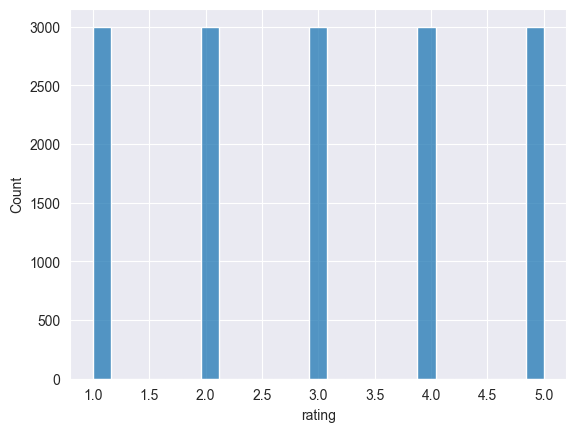

In [54]:
sns.histplot(df['rating'])

In [55]:
# –°–æ—Ö—Ä–∞–Ω–∏–º –æ–±—Ä–µ–∑–∞–Ω–Ω—ã–π –¥–∞—Ç–∞—Å–µ—Ç –¥–ª—è –¥–∞–ª—å–Ω–µ–π—à–µ–≥–æ —É–¥–æ–±–Ω–æ–≥–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
df.to_csv('dataset_cropped.tsv', sep='\t', index=False)

## –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –ø–æ–¥–∞—á–∏ –Ω–∞ –æ–±—É—á–µ–Ω–∏–µ

–î–ª—è –Ω–∞—á–∞–ª–∞ —Å—Ç—Ä—É–∫—Ç—É—Ä–∏—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ, –æ–±—ä–µ–¥–∏–Ω–∏–º rubrics, rating –∏ text –≤ –µ–¥–∏–Ω—ã–π —Ç–µ–∫—Å—Ç–æ–≤—ã–π —Ñ–æ—Ä–º–∞—Ç:

–í–∞–∂–Ω—ã–π –º–æ–º–µ–Ω—Ç —Å —Ñ–æ—Ä–º–∞—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–º–∏ —Ç–µ–∫—Å—Ç–∞–º–∏, —ç—Ç–æ –Ω—É–∂–Ω–æ –¥–ª—è —Ç–æ–≥–æ —á—Ç–æ –±—ã –ø–æ–º–æ—á—å —Å—Ç—Ä—É–∫—Ç—É—Ä–∏—Ä–æ–≤–∞—Ç—å –¥–∞–Ω–Ω—ã–µ –∏ –æ–±–ª–µ–≥—á–∏—Ç—å –∑–∞–¥–∞—á—É –º–æ–¥–µ–ª–∏. –¢–∞–∫ –∂–µ —ç—Ç–æ –Ω—É–∂–Ω–æ –¥–ª—è —É–ª—É—á—à–µ–Ω–∏—è –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏, —Ç–∞–∫ –ø–æ—Å–ª–µ –æ–±—É—á–µ–Ω–∏—è —ç—Ç–æ –±—É–¥–µ—Ç –ø–æ–º–æ–≥–∞—Ç—å –∑–∞–¥–∞–≤–∞—Ç—å –∫–æ–Ω—Ç–µ–∫—Å—Ç, –∏ –ø—Ä–∏ –ø–æ–¥–∞—á–µ –¥–∞–Ω–Ω—ã—Ö –≤ –≤–∏–¥–µ –Ω–∞–ø—Ä–∏–º–µ—Ä "Category: Restaurants. Rating: 5. Review:" –º–æ–¥–µ–ª—å —Å–≥–µ–Ω–µ—Ä–∏—Ä—É–µ—Ç –æ—Ç–∑—ã–≤, —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–π —Ä–µ—Å—Ç–æ—Ä–∞–Ω—É —Å –≤—ã—Å–æ–∫–∏–º —Ä–µ–π—Ç–∏–Ω–≥–æ–º.

–¢–∞–∫ –∂–µ –ø–æ–¥–æ–±–Ω–∞—è —Å—Ç—Ä—É–∫—Ç—É—Ä–∞ —É–ø—Ä–æ—Å—Ç–∏—Ç —Ä–∞—Å—à–∏—Ä–µ–Ω–∏–µ, —Ç–∞–∫ –∫–∞–∫ –º—ã –º–æ–∂–µ–º –¥–æ–±–∞–≤–ª—è—Ç—å —Å—é–¥–∞ –µ—â–µ –ø–æ–ª—è –µ—Å–ª–∏ –∑–∞—Ö–æ—Ç–∏–º –ø–æ–¥–∞–≤–∞—Ç—å –±–æ–ª—å—à–µ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –Ω–∞ –æ–±—É—á–µ–Ω–∏—è.

In [56]:
def format_review(row):
    return f"Category: {row['rubrics']}. Rating: {row['rating']}. Review: {row['text']}"

df['formatted_text'] = df.apply(format_review, axis=1)

–î–∞–ª–µ–µ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è.

–¢—É—Ç –Ω–∞–º –Ω—É–∂–Ω–æ –ø–µ—Ä–µ–≤–µ—Å—Ç–∏ –¥–∞–Ω–Ω—ã–µ –≤ —Ç–æ–∫–µ–Ω—ã, —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω–æ–≥–æ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä–∞ (–æ—Å—Ç–æ—Ä–æ–∂–Ω–æ, –ø—Ä–æ—Ü–µ—Å—Å –Ω–µ –±—ã—Å—Ç—Ä—ã–π, —É –º–µ–Ω—è –Ω–∞ –ª–æ–∫–∞–ª–∫–µ –∑–∞–Ω–∏–º–∞–µ—Ç –æ—Ç 5 –¥–æ 15–º–∏–Ω.):

In [57]:
# –ó–∞–≥—Ä—É–∑–∫–∞ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä–∞ GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")

tokenizer.pad_token = tokenizer.eos_token

# –¢–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö
def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

# –ü—Ä–∏–º–µ—Ä –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è
df['tokenized'] = df['formatted_text'].apply(tokenize_function)

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

–° –ø–æ–º–æ—â—å—é datasets –∏–∑ Hugging Face —Å–æ–∑–¥–∞–¥–∏–º –¥–∞—Ç–∞—Å–µ—Ç –¥–ª—è –æ–±—É—á–µ–Ω–∏—è:

In [58]:
dataset = Dataset.from_pandas(df[['formatted_text']])

# –¢–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è –≤—Å–µ—Ö —Ç–µ–∫—Å—Ç–æ–≤
def tokenize_data(batch):
    return tokenizer(batch['formatted_text'], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize_data, batched=True)


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [59]:
# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ train/test
train_test_split = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

–î–∞–ª–µ–µ –ø–æ–¥–≥–æ—Ç–æ–≤–∏–º –¥–∞–Ω–Ω—ã–µ –¥–ª—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ –¥–∞–Ω–Ω—ã—Ö –ø—Ä–∏ –æ–±—É—á–µ–Ω–∏–∏:

In [60]:
# –°–æ–∑–¥–∞–Ω–∏–µ collator –¥–ª—è –∑–∞–¥–∞—á–∏ —è–∑—ã–∫–æ–≤–æ–≥–æ –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏—è
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # GPT-2 –Ω–µ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç –º–∞—Å–∫–∏—Ä–æ–≤–∞–Ω–∏–µ
)

`DataCollatorForLanguageModeling` - –∏–Ω—Å—Ç—Ä—É–º–µ–Ω—Ç –∏–∑ –±–∏–±–ª–∏–æ—Ç–µ–∫–∏ Hugging Face, –∫–æ—Ç–æ—Ä—ã–π –¥–∏–Ω–∞–º–∏—á–µ—Å–∫–∏ –æ–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ—Ç –±–∞—Ç—á–∏ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –∑–∞–¥–∞—á NLP. –í –¥–∞–Ω–Ω–æ–º —Å–ª—É—á–∞–µ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –¥–ª—è –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∏ —Ç–æ–∫–µ–Ω–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –∫ –æ–±—É—á–µ–Ω–∏—é GPT-2, –µ—Å–ª–∏ –ø–µ—Ä–µ—á–∏—Å–ª–∏—Ç—å —á—Ç–æ –æ–Ω –¥–µ–ª–∞–µ—Ç:

1. –§–æ—Ä–º–∏—Ä—É–µ—Ç –±–∞—Ç—á–∏
2. –î–æ–±–∞–≤–ª–µ–µ—Ç —Å–ø–µ—Ü–∏–∞–ª—å–Ω–µ —Ç–æ–∫–µ–Ω—ã
3. –£–ø—Ä–æ—â—è–µ—Ç –æ–±—Ä–∞–±–æ—Ç–∫—É

–í –∏—Ç–æ–≥–µ –Ω–∞ —ç—Ç–∞–ø–µ –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∏ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –º—ã –ø–æ–ª—É—á–∏–ª–∏:

1. `train_dataset` –∏ `test_dataset` - –¥–∞—Ç–∞—Å–µ—Ç—ã –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –∏ –≤–∞–ª–¥–∏–∞—Ü–∏–∏
2. `data_collator` - "–ø–æ–¥–±–æ—Ä—â–∏–∫ –¥–∞–Ω–Ω—ã—Ö", –∏–Ω—Å—Ç—Ä—É–º–µ–Ω—Ç –¥–ª—è –æ–±—É—á–µ–Ω–∏—è
3. `tokenizer` - –æ–±—É—á–µ–Ω–Ω—ã–π —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä

## –û–±—É—á–µ–Ω–∏–µ

–î–∞–ª—å–Ω–µ–π—à–µ–µ –æ–±—É—á–µ–Ω–∏–µ –±—ã–ª–æ –≤—ã–ø–æ–ª–Ω—è–ª–æ—Å—å –≤ –æ—Ç–¥–µ–ª—å–Ω—ã—Ö –±–ª–∞–∫–Ω–æ—Ç–∞—Ö, –ø–æ –ø—Ä–∏—á–∏–Ω–∞–º —Å–ª–æ–∂–Ω–æ—Å—Ç–∏ –ø–µ—Ä–µ–∑–∞–ø—É—Å–∫–∞ —ç—Ç–æ–≥–æ (–¥–ª–∏—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ –æ–±—Ä–∞–±–æ—Ç–∫–∏ –¥–∞–Ω–Ω—ã—Ö), –∞ —Ç–∞–∫ –∂–µ —Å–æ–≤–º–µ—Å—Ç–∏–º–æ—Å—Ç–∏ (—Ä–∞–∑–Ω—ã–µ –æ—Å–∏ + –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ Google Colab).

–ù–µ–±–æ–ª—å—à–æ–π –æ—Ç—á–µ—Ç –ø–æ –æ–±—É—á–µ–Ω–∏—é:

–ü–µ—Ä–≤—ã–º —ç—Ç–∞–ø–æ–º –≤–∑—è–ª–∏—Å—å –æ–±—É—á–∞—Ç—å —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—É—é GPT-2 (–±–ª–∞–∫–Ω–æ—Ç —Å –æ–±—É—á–µ–Ω–∏–µ–º –∫–æ—Ç–æ—Ä–æ–π –Ω–∞—Ö–æ–¥–∏—Ç—Å—è –≤ [GPT2_train.ipynb](./GPT2_train.ipynb)). –†–µ–∑—É–ª—å—Ç–∞—Ç—ã —Ä–∞–∑–æ—á–∞—Ä–æ–≤—ã–≤–∞–ª–∏, –∫–∞–∫ –≤–µ–ª–∞ —Å–µ–±—è –º–æ–¥–µ–ª—å –º–æ–∂–Ω–æ –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å –≤ [—Å–∫—Ä–∏–Ω–∫–∞—Å—Ç–µ](./docs/screencast_gpt_2.md). –ü–æ–º–∏–º–æ –≤—Å–µ–≥–æ —Å–∫–æ—Ä–æ—Å—Ç—å –æ–±—É—á–µ–Ω–∏—è –æ—Å—Ç–∞–≤–ª—è–ª–∞ –∂–µ–ª–∞—Ç—å –ª—É—á—à–µ–≥–æ, –º–æ–¥–µ–ª—å –æ–±—É—á–∞–ª–∞—Å—å 14 —Å –ø–æ–ª–æ–≤–∏–Ω–æ–π —á–∞—Å–æ–≤ (–ª–æ–∫–∞–ª—å–Ω–æ –Ω–∞ 3060ti).

–î–∞–ª–µ–µ –±—ã–ª–æ –ø—Ä–∏–Ω—è—Ç–æ —Ä–µ—à–µ–Ω–∏–µ –∏—Å–∫–∞—Ç—å —á—Ç–æ-—Ç–æ –±–æ–ª–µ–µ –ø–æ–¥—Ö–æ–¥—è—â–µ–µ, —Ç–∞–∫ –∫–∞–∫ –Ω–µ –∏–º–µ–ª–æ —Å–º—ã—Å–ª–∞ –∑–∞–Ω–∏–º–∞—Ç—å—Å—è —É–ª—É—á—à–µ–Ω–∏–µ–º –∏ —Å–≤–µ—Ä–∫–æ–π –º–µ—Ç—Ä–∏–∫ —Å –Ω–∞—Å—Ç–æ–ª—å–∫–æ —Å–ª–∞–±—ã–º–∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏, –∏ –¥–æ–ª–≥–∏–º –æ–±—É—á–µ–Ω–∏–µ–º.

–ú—ã –Ω–∞—à–ª–∏ –º–æ–¥–µ–ª–∏ GPT-2 –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω—ã–µ –Ω–∞ ru –¥–∞–Ω–Ω—ã—Ö, –∏ —Ä–µ—à–∏–ª–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –∏—Ö. –ü–æ—Å–ª–µ —Ä–µ—Å–µ—Ä—á–∞ –ø–æ–¥—Ö–æ–¥—è—â–∏—Ö –º–æ–¥–µ–ª–µ–π, –Ω–∞—Ç–∫–Ω—É–ª–∏—Å—å –Ω–∞ –∏–¥–µ–∞–ª—å–Ω—ã–π –¥–ª—è –Ω–∞—Å –≤–∞—Ä–∏–∞–Ω—Ç - `ai-forever/rugpt3small_based_on_gpt2` - –ª–µ–≥–∫–æ–≤–µ—Å–Ω–∞—è –º–æ–¥–µ–ª—å –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω–∞—è –Ω–∞ ru –¥–∞–Ω–Ω—ã—Ö. –≠—Ç–æ –≥–∞—Ä–∞–Ω—Ç–∏—Ä–æ–≤–∞–ª–æ –ø–æ–ª—É—á–µ–Ω–∏–µ –±–æ–ª–µ–µ –ø—Ä–∏–µ–º–ª–µ–º—ã—Ö —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤, —Å –±–æ–ª–µ–µ –±—ã—Å—Ç—Ä—ã–º —Ä–∞–±–æ—á–∏–º –ø—Ä–æ—Ü–µ—Å—Å–æ–º.

–í –∏—Ç–æ–≥–µ –ø–æ—Å–ª–µ –ø–æ–¥–±–æ—Ä–∞ –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –æ–±—É—á–µ–Ω–∏—è, —É—á–∏—Ç—ã–≤–∞—è –±–∞–ª–∞–Ω—Å –≤—Ä–µ–º–µ–Ω–∏/–∫–∞—á–µ—Å—Ç–≤–∞, –º—ã —Å–º–æ–≥–ª–∏ –æ–±—É—á–∏—Ç—å –º–æ–¥–µ–ª—å –∑–∞ 24 –º–∏–Ω—É—Ç—ã, –∫–æ—Ç–æ—Ä–∞—è –¥–∞–≤–∞–ª–∞ –≥–æ—Ä–∞–∑–¥–æ –±–æ–ª–µ–µ —á—É–≤—Å—Ç–≤–∏—Ç–µ–ª—å–Ω—ã–µ –∏ –ª–æ–≥–∏—á–µ—Å–∫–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã, —Å–∫—Ä–∏–Ω–∫–∞—Å—Ç —Å –Ω–∏–º–∏ –º–æ–∂–Ω–æ –ø–æ—Å–º–æ—Ç—Ä–µ—Ç—å [—Ç—É—Ç](./docs/screencast_gpt_2_ru.md), –∞ –ø—Ä–æ—Ü–µ—Å—Å –æ–±—É—á–µ–Ω–∏—è - [GPT2_RU_train.ipynb](./GPT2_RU_train.ipynb). 

## –°–æ–≤–µ—Ä—à–µ–Ω—Å—Ç–≤–æ–≤–∞–Ω–∏–µ

## –ê–Ω–∞–ª–∏–∑

–ó–∞–≥—Ä—É–∂–∞–µ–º –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω—É—é –º–æ–¥–µ–ª—å

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("./model/train-model-1")
model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path="./model/train-model-1",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)
# –ü–µ—Ä–µ–º–µ—â–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –Ω–∞ GPU –∏–ª–∏ CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

–í –∫–∞—á–µ—Å—Ç–≤–µ –º–µ—Ç—Ä–∏–∫–∏ –≤—ã–±–µ—Ä–µ–º BLUE

In [ ]:

# –ó–∞–≥—Ä—É–∂–∞–µ–º —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ –º–µ—Ç—Ä–∏–∫–∏ –∏–∑ –±–∏–±–ª–∏–æ—Ç–µ–∫–∏ nltk
from nltk.translate.bleu_score import sentence_bleu

–ü–æ—Å—á–∏—Ç–∞–µ–º –æ—Ü–µ–Ω–∫—É 5 —Ä–∞–∑

In [ ]:
for n in range(0,5):   
   numb = randint(0, 498639)
   reference =  df['text'].loc[numb]
   rating =  df['rating'].loc[numb]
   rubrics = df['rubrics'].loc[numb]
   input_text = f"rubrics = {rubrics}\nrating = {rating}\nReview:"
   inputs = tokenizer(input_text, return_tensors="pt").to(device)
   output = model.generate(
      **inputs,
      max_length=60,
      temperature=0.8,
      no_repeat_ngram_size=2,
      do_sample=True,
      num_return_sequences=1,
      eos_token_id=tokenizer.eos_token_id,  
      pad_token_id=tokenizer.eos_token_id,  
      early_stopping=True,  
      top_k=30,         
      top_p=0.8,        
   )
   print('–û—Ü–µ–Ω–∫–∞ –Ω–æ–º–µ—Ä ', n+1)
   print('Rating=', rating, 'Rubrics=', rubrics)
   for i, sequence in enumerate(output):
      print(reference)
      generated_text = tokenizer.decode(sequence, skip_special_tokens=True)
      candidate = re.findall(r'(?<=Review: ).*', generated_text)[0]
      print(candidate)
      score = sentence_bleu(reference, candidate)
      print(score)

–û—Ü–µ–Ω–∫–∞ –Ω–æ–º–µ—Ä  1
Rating= 5 Rubrics= –°—É–ø–µ—Ä–º–∞—Ä–∫–µ—Ç;–ì–∏–ø–µ—Ä–º–∞—Ä–∫–µ—Ç
—è –Ω–µ –æ—à–∏–±—É—Å—å –µ—Å–ª–∏ –Ω–∞–∑–æ–≤—É —ç—Ç–æ—Ç —Ç–æ—Ä–≥–æ–≤—ã–π —Ü–µ–Ω—Ç—Ä —Å–∞–º—ã–º –ø–æ–ø—É–ª—è—Ä–Ω—ã–º –≤ –≥–æ—Ä–æ–¥–µ –º–Ω–æ–≥–æ–æ–±—Ä–∞–∑–Ω—ã–µ –±—É—Ç–∏–∫–∏ –∑–æ–Ω—ã –æ—Ç–¥—ã—Ö–∞ –¥–µ—Ç—Å–∫–∏–µ –ø–ª–æ—â–∞–¥–∫–∏ –Ω—É –∏ –∫–æ–Ω–µ—á–Ω–æ –º–∞—è–∫ –≤—Å–µ –¥–ª—è –≤—Å–µ—Ö –∏ –ø—Ä–æ–¥—É–∫—Ç—ã –∏ —Ç–µ–∫—Å—Ç–∏–ª—å –∏ –∏–≥—Ä—É—à–∫–∏ –∫–∞—á–µ—Å—Ç–≤–æ –∫–æ–Ω–µ—á–Ω–æ —Å–æ–º–Ω–∏—Ç–µ–ª—å–Ω–æ–µ –Ω–æ —Ü–µ–Ω—ã –ø–æ–∫—É–ø–∞—é—Ç
–º–∞–≥–∞–∑–∏–Ω —Ä–∞—Å–ø–æ–ª–æ–∂–µ–Ω –≤ —Ü–µ–Ω—Ç—Ä–µ –≥–æ—Ä–æ–¥–∞ —Ä—è–¥–æ–º —Å –º–µ—Ç—Ä–æ  —É–¥–æ–±–Ω–æ —Ä–∞—Å–ø–æ–ª–æ–∂–µ–Ω –º–∞–≥–∞–∑–∏–Ω–æ–º  –µ—Å—Ç—å –≤—Å–µ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ–µ –¥–ª—è –ø—Ä–∏–≥–æ—Ç–æ–≤–ª–µ–Ω–∏—è –ø–∏—â–∏ –∏ —Ç–æ–≤–∞—Ä–æ–≤  –º–∞–≥–∞–∑–∏–Ω –Ω–∞—Ö–æ–¥–∏—Ç—Å—è –Ω–∞ –ø–µ—Ä–≤–æ–º —ç—Ç–∞–∂–µ –∂–∏–ª–æ–≥–æ –¥–æ–º–∞ —Ä—è–¥–æ–º —Ä–∞—Å–ø–æ–ª–æ–∂–µ–Ω –ø—Ä–æ–¥—É–∫—Ç–æ–≤—ã–π –º–∞–≥–∞–∑–∏–Ω –∏ –ø—Ä–æ–¥—É–∫—Ç–æ–≤–∞—è –≥–∏–ø–µ—Ä–º–∞—Ä–∫–µ—Ç
1.0529201163813138e-231
–û—Ü–µ–Ω–

–ö–∞–∫ –≤–∏–¥–∏–º - –æ—Ü–µ–Ω–∫–∞ —Å—Ç—Ä–µ–º–∏—Ç—Å—è –∫ 0. –ù–æ —ç—Ç–æ –∏ –Ω–µ—É–¥–∏–≤–∏—Ç–µ–ª—å–Ω–æ, –∏—Å—Ö–æ–¥–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –¥–ª—è –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ –æ—Ç–∑—ã–≤–∞ –Ω–µ –≤–µ–ª–∏–∫–∏, –∞ –≤–æ—Ç —Ä–∞–∑–Ω–æ–æ–±—Ä–∞–∑–∏–µ –≤–æ–∑–º–æ–∂–Ω—ã—Ö –æ—Ç–∑—ã–≤–æ–≤ –æ–≥—Ä–æ–º–Ω–æ.
–ü–æ–ø—Ä–æ–±—É–µ–º –≤—ã–ø–æ–ª–Ω–∏—Ç—å –æ—Ü–µ–Ω–∫—É Meteor.

In [ ]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ –º–µ—Ç—Ä–∏–∫–∏ –∏–∑ –±–∏–±–ª–∏–æ—Ç–µ–∫–∏ nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vald\AppData\Roaming\nltk_data...


True

–ú–æ–¥–∏—Ñ–∏—Ü–∏—Ä—É–µ–º —Ü–∏–∫–ª –æ—Ü–µ–Ω–∫–∏ –∏ —Å–Ω–æ–≤–∞ —Ä–∞—Å—á–∏—Ç–∞–º 5 –æ—Ü–µ–Ω–æ–∫

In [ ]:
for n in range(0,5):   
    numb = randint(0, 498639)
    reference =  df['text'].loc[numb]
    rating =  df['rating'].loc[numb]
    rubrics = df['rubrics'].loc[numb]
    input_text = f"rubrics = {rubrics}\nrating = {rating}\nReview:"
    inputs = tokenizer(input_text, return_tensors="pt").to(device)
    output = model.generate(
        **inputs,
        max_length=60,
        temperature=0.8,
        no_repeat_ngram_size=2,
        do_sample=True,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,  
        pad_token_id=tokenizer.eos_token_id,  
        early_stopping=True,  
        top_k=30,         
        top_p=0.8,        
    )
    print('–û—Ü–µ–Ω–∫–∞ –Ω–æ–º–µ—Ä ', n+1)
    print('Rating=', rating, 'Rubrics=', rubrics)
    for i, sequence in enumerate(output):
        print(reference)
        generated_text = tokenizer.decode(sequence, skip_special_tokens=True)
        candidate = re.findall(r'(?<=Review:).*', generated_text)[0]
        print(candidate)
        ref_token= word_tokenize(reference)
        cand_token= word_tokenize(candidate) 
        score = meteor_score([ref_token], cand_token)
        print(f"METEOR Score: {score:.4f}")

–û—Ü–µ–Ω–∫–∞ –Ω–æ–º–µ—Ä  1
Rating= 3 Rubrics= –ü–µ–∫–∞—Ä–Ω—è;–ë—ã—Å—Ç—Ä–æ–µ –ø–∏—Ç–∞–Ω–∏–µ;–ö–æ–Ω–¥–∏—Ç–µ—Ä—Å–∫–∞—è
–Ω–∞–∏–º–µ–Ω–µ–µ –≤–∫—É—Å–Ω–∞—è —à–∞—É—Ä–º–∞ –Ω–∞ —Ä–∞–π–æ–Ω–∞—Ö –Ω–∏–∫–∞—è –ø—Ä–æ—Å—Ç–æ –ø–µ—Ä–µ–π–¥–∏—Ç–µ —á–µ—Ä–µ–∑ –ª–æ—Å–∏–Ω–æ–æ—Å—Ç—Ä–æ–≤—Å–∫–∏–π –º–æ—Å—Ç –∏ —Å—Ä–∞–∑—É —Ä—è–¥–æ–º —Å —á–∞—Å–æ–≤–Ω–µ–π –≤–æ–∑—å–º–∏—Ç–µ –Ω–µ–±–æ –∏ –∑–µ–º–ª—è
 –∑–∞–∫–∞–∑–∞–ª–∞ —Å–µ–≥–æ–¥–Ω—è –ø–∏—Ü—Ü—É —Å –∫—Ä–µ–≤–µ—Ç–∫–∞–º–∏ –∏ –∫—Ä–µ–∫—Å–∞–º–∏ –≤ –∫–∞—á–µ—Å—Ç–≤–µ –∑–∞–∫—É—Å–∫–∏ –∏ –ø–æ–ª—É—á–∏–ª–∞ —á–µ–∫ –Ω–∞ —Å–∫–∏–¥–∫—É –≤ —Ä–∞–∑–º–µ—Ä–µ 590 —Ä—É–±–ª–µ–π –∑–∞ –∑–∞–∫–∞–∑ —Å –¥–æ—Å—Ç–∞–≤–∫–æ–π –≤
METEOR Score: 0.0980
–û—Ü–µ–Ω–∫–∞ –Ω–æ–º–µ—Ä  2
Rating= 5 Rubrics= –ê–ø—Ç–µ–∫–∞
–æ—Ç–ª–∏—á–Ω–∞—è –∞–ø—Ç–µ–∫–∞ —Ö–æ—Ä–æ—à–µ–µ –æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ–±–æ–ª—å—à–æ–π –∞—Å—Å–æ—Ä—Ç–∏–º–µ–Ω—Ç –ª–µ–∫–∞—Ä—Å—Ç–≤
 —è –≤ –≤–æ—Å—Ç–æ—Ä–≥–µ –æ—Ç —ç—Ç–æ–π –∞–ø—Ç–µ–∫–∏  —Å–ø–∞—Å–∏–±–æ –∑–∞ —Ç–æ —á—Ç–æ –≤—ã –µ—Å—Ç—å –≤—Å–µ–≥–¥–∞ –∏ –≤—Å–µ–≥–¥–∞  —è –≤—Å–µ–≥–¥–∞ —Å –±–æ–ª—å—à–∏–º —É–¥–æ–≤–æ–ª—å—Å—Ç–≤–∏–µ–º –

–ö–∞–∫ –≤–∏–¥–∏–º, –æ—Ü–µ–Ω–∫–∞ Meteor —Ç–∞–∫ –∂–µ –Ω–µ –≤—ã—Å–æ–∫–∞, —á—Ç–æ –æ–±—ä—è—Å–Ω—è–µ—Ç—Å—è –±–æ–ª—å—à–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –≤–æ–∑–º–æ–∂–Ω—ã—Ö –≤–∞—Ä–∏–∞–Ω—Ç–æ–≤ –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ –ø—Ä–∏ –Ω–µ–±–æ–ª—å—à–æ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–µ –∏—Å—Ö–æ–¥–Ω—ã—Ö –≤–∞—Ä–∏–∞–Ω—Ç–æ–≤.

### –í—ã–≤–æ–¥

BLUE (best linear unbiased estimate) ‚Äî —ç—Ç–æ ¬´–Ω–∞–∏–ª—É—á—à–∞—è –ª–∏–Ω–µ–π–Ω–∞—è –Ω–µ—Å–º–µ—â—ë–Ω–Ω–∞—è –æ—Ü–µ–Ω–∫–∞¬ª. 

–î—Ä—É–≥–∏–º–∏ —Å–ª–æ–≤–∞–º–∏, —ç—Ç–æ –æ—Ü–µ–Ω–∫–∞ —Å –Ω–∞–∏–º–µ–Ω—å—à–µ–π –¥–∏—Å–ø–µ—Ä—Å–∏–µ–π –≤ –∫–ª–∞—Å—Å–µ –≤—Å–µ—Ö –ª–∏–Ω–µ–π–Ω—ã—Ö –Ω–µ—Å–º–µ—â—ë–Ω–Ω—ã—Ö –æ—Ü–µ–Ω–æ–∫. –æ–Ω–∞ –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç, –∫–∞–∫ —Å–∏–ª—å–Ω–æ –æ—Ü–µ–Ω–∏–≤–∞–µ–º—ã–π —Ñ—Ä–∞–≥–º–µ–Ω—Ç –æ—Ç–ª–∏—á–∞–µ—Ç—Å—è –æ—Ç —Ä–µ—Ñ–µ—Ä–µ–Ω—Å–Ω–æ–≥–æ. –ò–∑–Ω–∞—á–∞–ª—å–Ω–æ —ç—Ç–∞ –º–µ—Ç—Ä–∏–∫–∞ –ø—Ä–µ–¥–Ω–∞–∑–Ω–∞—á–µ–Ω–∞ –¥–ª—è –æ—Ü–µ–Ω–∫–∏ —Ç–æ—á–Ω–æ—Å—Ç–∏ –ø–µ—Ä–µ–≤–æ–¥–∞ –º–æ–¥–µ–ª—å—é, –ø—É—Ç—ë–º —Å—Ä–∞–≤–Ω–µ–Ω–∏—è —Ç–µ–∫—Å—Ç–∞ —Å–≥–µ–Ω–µ—Ä–∏—Ä–æ–≤–∞–Ω–Ω–æ–≥–æ –ø—Ä–µ–≤–æ–¥–∞ –∏ —ç—Ç–∞–ª–æ–Ω–Ω–æ–≥–æ –ø–µ—Ä–µ–≤–æ–¥–∞ –∏—Å—Ö–æ–¥–Ω–æ–≥–æ —Ç–µ–∫—Å—Ç–∞ —á–µ–ª–æ–≤–µ–∫–æ–º.

METEOR (Metric for Evaluation of Translation with Explicit ORdering (2004)) ‚Äî –º–µ—Ç—Ä–∏–∫–∞ –¥–ª—è –æ—Ü–µ–Ω–∫–∏ –∫–∞—á–µ—Å—Ç–≤–∞ –º–∞—à–∏–Ω–Ω–æ–≥–æ –ø–µ—Ä–µ–≤–æ–¥–∞. –ú–µ—Ç—Ä–∏–∫–∞ –±–∞–∑–∏—Ä—É–µ—Ç—Å—è –Ω–∞ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–∏ n-–≥—Ä–∞–º–º –∏ –æ—Ä–∏–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–∞ –Ω–∞ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–æ–π –∏ —Ç–æ—á–Ω–æ–π –æ—Ü–µ–Ω–∫–∏ –∏—Å—Ö–æ–¥–Ω–æ–≥–æ —Ç–µ–∫—Å—Ç–∞. –í –æ—Ç–ª–∏—á–∏–µ –æ—Ç –º–µ—Ç—Ä–∏–∫–∏ BLEU[–∞–Ω–≥–ª.], –¥–∞–Ω–Ω–∞—è –º–µ—Ç—Ä–∏–∫–∞ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç —Ñ—É–Ω–∫—Ü–∏–∏ —Å–æ–ø–æ—Å—Ç–∞–≤–ª–µ–Ω–∏—è —Å–∏–Ω–æ–Ω–∏–º–æ–≤ –≤–º–µ—Å—Ç–µ —Å —Ç–æ—á–Ω—ã–º —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏–µ–º —Å–ª–æ–≤. –ú–µ—Ç—Ä–∏–∫–∞ –±—ã–ª–∞ —Ä–∞–∑—Ä–∞–±–æ—Ç–∞–Ω–∞, —á—Ç–æ–±—ã —Ä–µ—à–∏—Ç—å –ø—Ä–æ–±–ª–µ–º—ã, –∫–æ—Ç–æ—Ä—ã–µ –±—ã–ª–∏ –Ω–∞–π–¥–µ–Ω—ã –≤ –±–æ–ª–µ–µ –ø–æ–ø—É–ª—è—Ä–Ω–æ–π –º–µ—Ç—Ä–∏–∫–µ BLEU, –∞ —Ç–∞–∫–∂–µ —Å–æ–∑–¥–∞—Ç—å —Ö–æ—Ä–æ—à—É—é –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—é —Å –æ—Ü–µ–Ω–∫–æ–π —ç–∫—Å–ø–µ—Ä—Ç–æ–≤ –Ω–∞ —É—Ä–æ–≤–Ω–µ —Å–ª–æ–≤–æ—Å–æ—á–µ—Ç–∞–Ω–∏–π –∏–ª–∏ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π.

–ö–∞–∫ –≤–∏–¥–∏–º, –æ–±–µ –º–µ—Ç—Ä–∏–∫–∏ –∏–∑–Ω–∞—á–∞–ª—å–Ω–æ –Ω–∞—Ü–µ–ª–µ–Ω—ã –Ω–∞ —Å—Ä–∞–≤–Ω–µ–Ω–∏–µ —Å–≥–µ–Ω–µ—Ä–∏—Ä–æ–≤–∞–Ω–Ω–æ–≥–æ –∏ —ç—Ç–∞–ª–æ–Ω–Ω–æ–≥–æ —Ç–µ–∫—Å—Ç–∞. –ø—Ä–∏ —ç—Ç–æ–º –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ—Ç—Å—è, —á—Ç–æ —á–∏—Å–ª–æ —Ç—Ä–∞–∫—Ç–æ–≤–æ–∫ –∏–∑–Ω–∞—á–∞–ª—å–Ω–æ –Ω–µ –≤–µ–ª–∏–∫–æ (–í –º–µ—Ç—Ä–∏–∫–µ BLUE —Ç—Ä–µ–±—É–µ—Ç—Å—è —Ç–æ—á–Ω–æ–µ —Å–æ–≤–ø–∞–¥–µ–Ω–∏–µ, –∞ METEOR —É—á–∏—Ç—ã–≤–∞–µ—Ç –Ω–∞–ª–∏—á–∏–µ —Å–∏–Ω–æ–Ω–∏–º–æ–≤ –∏ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö—ä —Å–ª–æ–≤–æ—Ñ–æ—Ä–º).
–ù–æ –≤ —Å–ª—É—á–∞–µ —Å–æ–∑–¥–∞–Ω–∏—è –≤–æ–ª—å–Ω–æ–≥–æ —Ç–µ–∫—Å—Ç–∞ –¥–∞–Ω–Ω—ã–µ –º–µ—Ç—Ä–∏–∫–∏ –ø–æ–¥—Ö–æ–¥—è—Ç —Å–ª–∞–±–æ, —Ç–∞–∫ –∫–∞–∫ –æ–¥–∏–Ω –∏ —Ç–æ—Ç –∂–µ —Ç–∏–ø –æ—Ä–≥–∞–Ω–∏–∑—Ü–∏–∏ —Å –æ–¥–Ω–æ–π –æ—Ü—Ü–µ–Ω–∫–æ–π –º—ã –º–æ–∂–µ–º –æ–ø–∏—Å–∞—Ç—å –¥–æ–≤–æ–ª—å–Ω–æ –±–æ–ª—å—à–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–æ–º –≤–∞—Ä–∏–∞–Ω—Ç–æ–≤.
–ü–æ—ç—Ç–æ–º –Ω–∞–∏–±–æ–ª–µ–µ –ø—Ä–∞–≤–∏–ª—å–Ω—ã–º –±—É–¥–µ—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤—Ç—å —ç–∫—Å–ø–µ—Ä—Ç–Ω—ã–π –∞–Ω–∞–ª–∏–∑ –∏ —Å–∞–º–æ—Å—Ç–æ—è—Ç–µ–ª—å–Ω–æ –æ–ø—Ä–µ–¥–µ–ª–∏—Ç—å –Ω–∞ —Å–∫–æ–ª—å–∫–æ –µ—Å—Ç–µ—Å—Ç–≤–µ–Ω–Ω–æ –∏ –æ—Ä–≥–∞–Ω–∏—á–Ω–æ —Å–º–æ—Ç—Ä–∏—Ç—Å—è –æ—Ç–∑—ã–≤.

–î–ª—è –Ω–∞—à–µ–π –º–æ–¥–µ–ª–∏ –º–æ–∂–Ω–æ –æ—Ç–º–µ—Ç–∏—Ç—å, —á—Ç–æ –∑–∞—á–∞—Å—Ç—É—é –æ—Ç–∑—ã–≤—ã –≤—ã–≥–ª—è–¥—è—Ç –∫–∞–∫ —Å–≤—è–∑–Ω—ã–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –ø–æ–¥—Ö–æ–¥—è—â–∏–Ω–µ –¥–ª—è –∑–∞–ø—Ä–∞—à–∏–≤–∞–µ–º—ã—Ö –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏–π —Å —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–º–∏ —Ä–µ–π—Ç–∏–Ω–≥–∞–º–∏. –û–¥–Ω–∞–∫–æ –Ω–µ —Ä–µ–¥–∫–æ –º–æ–∂–Ω–æ –≤—Å—Ç—Ä–µ—Ç–∏—Ç—å –∏ —Å–ª–æ–±–æ—Å–≤—è–∑–Ω—ã–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è. –≠—Ç–æ –º–æ–∂–Ω–æ –æ–±—ä—è—Å–Ω–∏—Ç—å –≤—ã–±–æ—Ä–æ–º (–≤ —Å–≤—è–∑–∏ —Å —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–º–∏ –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è–º–∏) –¥–æ–≤–æ–ª—å–Ω–æ —Å–ª–∞–±–æ–π –∏–∑–Ω–∞—á–∞–ª—å–Ω–æ –∏—Å—Ö–æ–¥–Ω–æ–π –º–æ–¥–µ–ª–∏.

–î–ª—è —É–ª—É—á—à–µ–Ω–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –ø—Ä–µ–¥–ª–∞–≥–∞–µ—Ç—Å—è –¥–∞–ª—å–Ω–µ–π—à–µ–µ –¥–æ–æ–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏, –∏–ª–∏ –∑–∞–º–µ–Ω–∞ –º–æ–¥–µ–ª–∏ –Ω–∞ –±–æ–ª–µ–µ —Å–∏–ª—å–Ω—É—é —Å –µ—ë –æ–±—É—á–µ–Ω–∏–µ–º.


## –ò—Ç–æ–≥

–ò—Ç–æ–≥–æ–º —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–∏ —Å—Ç–∞–ª–æ –∫–ª–∏–µ–Ω—Ç-—Å–µ—Ä–≤–µ—Ä–Ω–æ–µ –ø—Ä–∏–ª–æ–∂–µ–Ω–∏–µ, –≥–¥–µ –ø–æ–ª—å–∑–æ–≤–∞–∞—Ç–µ–ª—å –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤—É–µ—Ç —Å –∏–Ω—Ç–µ—Ä—Ñ–µ–π—Å–æ–º –æ–±–æ–ª–æ—á–∫–∏ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è, —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω–Ω–æ–π –Ω–∞ streamlit, –∞ –Ω–µ–ø–æ—Å—Ä–µ–¥—Å—Ç–≤–µ–Ω–Ω–æ –≥–µ–Ω–µ—Ä–∞—Ü–∏—è –ø—Ä–æ–∏—Å—Ö–æ–¥–∏—Ç –≤ –º–æ–¥—É–ª–µ —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω–Ω–æ–º –Ω–∞ –Ω–∞ FastAPI.

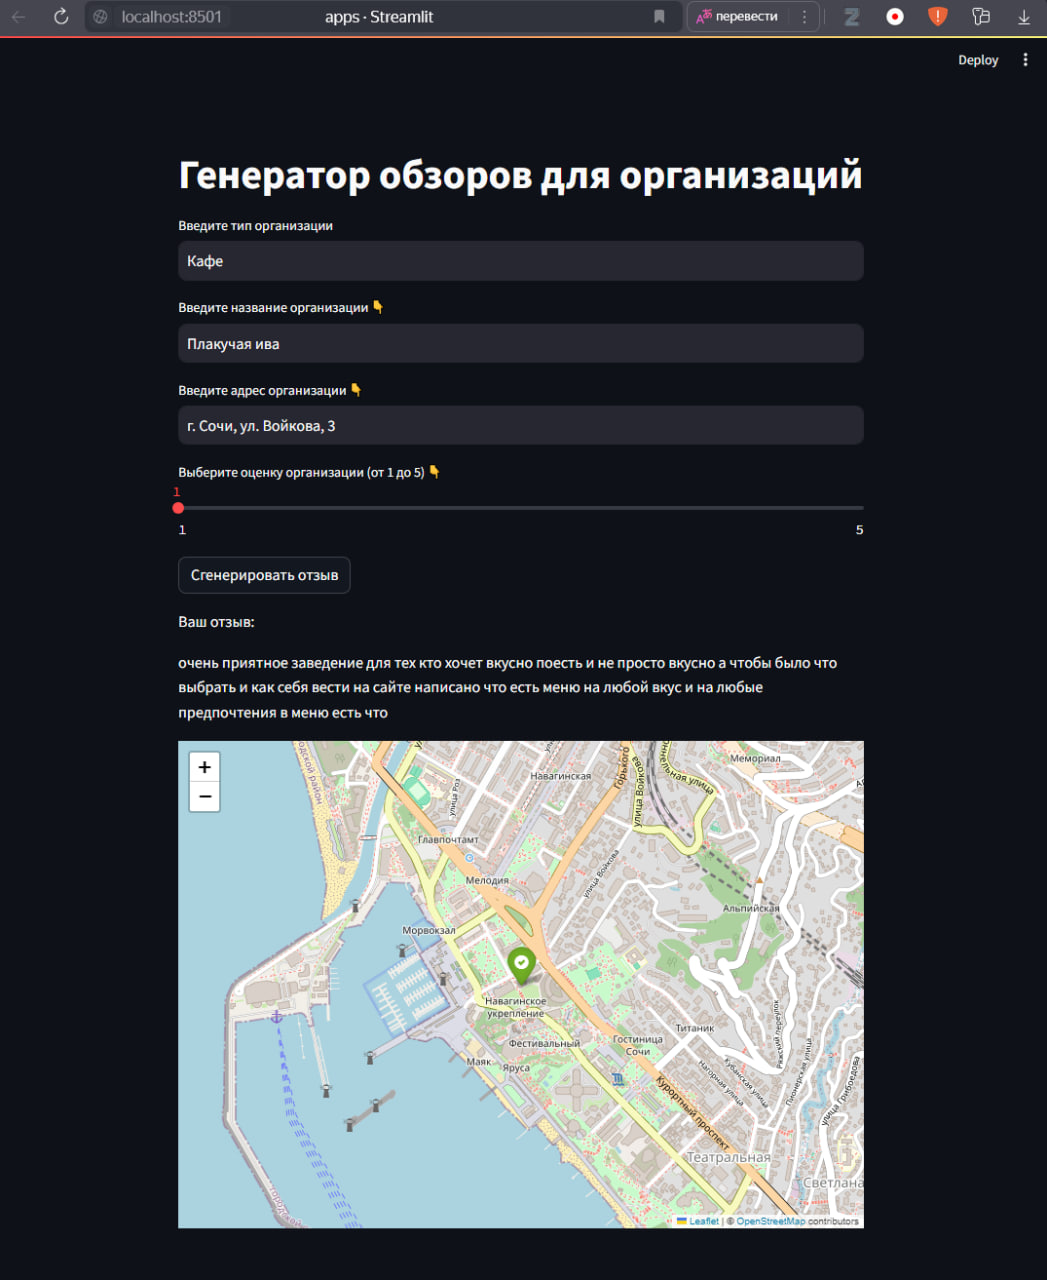